<a href="https://colab.research.google.com/github/shuaigezhu/starDist/blob/master/GaiaData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Import**

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import collections
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
from math import pi
from random import randint
from torch import nn
from torch.distributions.kl import kl_divergence
from sklearn import preprocessing
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
import glob

Using TensorFlow backend.


### **Normalizaton**

In [0]:
def Normalization(data):
  data_f = data.astype(float)
  data_mean = np.mean(data_f, axis=0, keepdims=True)
  data_n = data_f - data_mean
  data_range = np.max(np.abs(data_n), axis=0, keepdims=True)
  data_n = data_n / data_range
  
  return data_n

### **MLP**

In [0]:
def batch_mlp(input, output_sizes, variable_scope):
  """Apply MLP to the final axis of a 3D tensor (reusing already defined MLPs).
  
  Args:
    input: input tensor of shape [B,n,d_in].
    output_sizes: An iterable containing the output sizes of the MLP as defined 
        in `basic.Linear`.
    variable_scope: String giving the name of the variable scope. If this is set
        to be the same as a previously defined MLP, then the weights are reused.
    
  Returns:
    tensor of shape [B,n,d_out] where d_out=output_sizes[-1]
  """
  # Get the shapes of the input and reshape to parallelise across observations
  batch_size, _, filter_size = input.shape.as_list()
  output = tf.reshape(input, (-1, filter_size))
  output.set_shape((None, filter_size))

  # Pass through MLP
  with tf.variable_scope(variable_scope, reuse=tf.AUTO_REUSE):
    for i, size in enumerate(output_sizes[:-1]):
      output = tf.nn.relu(
          tf.layers.dense(output, size, name="layer_{}".format(i)))

    # Last layer without a ReLu
    output = tf.layers.dense(
        output, output_sizes[-1], name="layer_{}".format(i + 1))

  # Bring back into original shape
  output = tf.reshape(output, (batch_size, -1, output_sizes[-1]))
  return output

### **Deterministic Encoder**

In [0]:
class DeterministicEncoder(object):
  """The Deterministic Encoder."""

  def __init__(self, output_sizes, attention):
    """(A)NP deterministic encoder.

    Args:
      output_sizes: An iterable containing the output sizes of the encoding MLP.
      attention: The attention module.
    """
    self._output_sizes = output_sizes
    self._attention = attention

  def __call__(self, context_x, context_y, target_x):
    """Encodes the inputs into one representation.

    Args:
      context_x: Tensor of shape [B,observations,d_x]. For this 1D regression
          task this corresponds to the x-values.
      context_y: Tensor of shape [B,observations,d_y]. For this 1D regression
          task this corresponds to the y-values.
      target_x: Tensor of shape [B,target_observations,d_x]. 
          For this 1D regression task this corresponds to the x-values.

    Returns:
      The encoded representation. Tensor of shape [B,target_observations,d]
    """

    # Concatenate x and y along the filter axes
    encoder_input = tf.concat([context_x, context_y], axis=-1)

    # Pass final axis through MLP
    hidden = batch_mlp(encoder_input, self._output_sizes, 
                       "deterministic_encoder")

    # Apply attention
    with tf.variable_scope("deterministic_encoder", reuse=tf.AUTO_REUSE):
        hidden = self._attention(context_x, target_x, hidden)

    return hidden

### **Latent Encoder**

In [0]:
class LatentEncoder(object):
  """The Latent Encoder."""

  def __init__(self, output_sizes, num_latents):
    """(A)NP latent encoder.

    Args:
      output_sizes: An iterable containing the output sizes of the encoding MLP.
      num_latents: The latent dimensionality.
    """
    self._output_sizes = output_sizes
    self._num_latents = num_latents

  def __call__(self, x, y):
    """Encodes the inputs into one representation.

    Args:
      x: Tensor of shape [B,observations,d_x]. For this 1D regression
          task this corresponds to the x-values.
      y: Tensor of shape [B,observations,d_y]. For this 1D regression
          task this corresponds to the y-values.

    Returns:
      A normal distribution over tensors of shape [B, num_latents]
    """

    # Concatenate x and y along the filter axes
    encoder_input = tf.concat([x, y], axis=-1)

    # Pass final axis through MLP
    hidden = batch_mlp(encoder_input, self._output_sizes, "latent_encoder")
      
    # Aggregator: take the mean over all points
    hidden = tf.reduce_mean(hidden, axis=1)
    
    # Have further MLP layers that map to the parameters of the Gaussian latent
    with tf.variable_scope("latent_encoder", reuse=tf.AUTO_REUSE):
      # First apply intermediate relu layer 
      hidden = tf.nn.relu(
          tf.layers.dense(hidden, 
                          (self._output_sizes[-1] + self._num_latents)/2, 
                          name="penultimate_layer"))
      # Then apply further linear layers to output latent mu and log sigma
      mu = tf.layers.dense(hidden, self._num_latents, name="mean_layer")
      log_sigma = tf.layers.dense(hidden, self._num_latents, name="std_layer")
      
    # Compute sigma
    sigma = 0.1 + 0.9 * tf.sigmoid(log_sigma)

    return tf.contrib.distributions.Normal(loc=mu, scale=sigma)

### **Decoder**

In [0]:
class Decoder(object):
  """The Decoder."""

  def __init__(self, output_sizes):
    """(A)NP decoder.

    Args:
      output_sizes: An iterable containing the output sizes of the decoder MLP 
          as defined in `basic.Linear`.
    """
    self._output_sizes = output_sizes

  def __call__(self, representation, target_x):
    """Decodes the individual targets.

    Args:
      representation: The representation of the context for target predictions. 
          Tensor of shape [B,target_observations,?].
      target_x: The x locations for the target query.
          Tensor of shape [B,target_observations,d_x].

    Returns:
      dist: A multivariate Gaussian over the target points. A distribution over
          tensors of shape [B,target_observations,d_y].
      mu: The mean of the multivariate Gaussian.
          Tensor of shape [B,target_observations,d_x].
      sigma: The standard deviation of the multivariate Gaussian.
          Tensor of shape [B,target_observations,d_x].
    """
    # concatenate target_x and representation
    hidden = tf.concat([representation, target_x], axis=-1)
    
    # Pass final axis through MLP
    hidden = batch_mlp(hidden, self._output_sizes, "decoder")

    # Get the mean an the variance
    mu, log_sigma = tf.split(hidden, 2, axis=-1)

    # Bound the variance
    sigma = 0.1 + 0.9 * tf.nn.softplus(log_sigma)

    # Get the distribution
    dist = tf.contrib.distributions.MultivariateNormalDiag(
        loc=mu, scale_diag=sigma)

    return dist, mu, sigma

### **Model**

In [0]:
class LatentModel(object):
  """The (A)NP model."""

  def __init__(self, latent_encoder_output_sizes, num_latents,
               decoder_output_sizes, use_deterministic_path=True, 
               deterministic_encoder_output_sizes=None, attention=None):
    """Initialises the model.

    Args:
      latent_encoder_output_sizes: An iterable containing the sizes of hidden 
          layers of the latent encoder.
      num_latents: The latent dimensionality.
      decoder_output_sizes: An iterable containing the sizes of hidden layers of
          the decoder. The last element should correspond to d_y * 2
          (it encodes both mean and variance concatenated)
      use_deterministic_path: a boolean that indicates whether the deterministic
          encoder is used or not.
      deterministic_encoder_output_sizes: An iterable containing the sizes of 
          hidden layers of the deterministic encoder. The last one is the size 
          of the deterministic representation r.
      attention: The attention module used in the deterministic encoder.
          Only relevant when use_deterministic_path=True.
    """
    self._latent_encoder = LatentEncoder(latent_encoder_output_sizes, 
                                         num_latents)
    self._decoder = Decoder(decoder_output_sizes)
    self._use_deterministic_path = use_deterministic_path
    if use_deterministic_path:
      self._deterministic_encoder = DeterministicEncoder(
          deterministic_encoder_output_sizes, attention)
    

  def __call__(self, query, num_targets, target_y=None):
    """Returns the predicted mean and variance at the target points.

    Args:
      query: Array containing ((context_x, context_y), target_x) where:
          context_x: Tensor of shape [B,num_contexts,d_x]. 
              Contains the x values of the context points.
          context_y: Tensor of shape [B,num_contexts,d_y]. 
              Contains the y values of the context points.
          target_x: Tensor of shape [B,num_targets,d_x]. 
              Contains the x values of the target points.
      num_targets: Number of target points.
      target_y: The ground truth y values of the target y. 
          Tensor of shape [B,num_targets,d_y].

    Returns:
      log_p: The log_probability of the target_y given the predicted
          distribution. Tensor of shape [B,num_targets].
      mu: The mean of the predicted distribution. 
          Tensor of shape [B,num_targets,d_y].
      sigma: The variance of the predicted distribution.
          Tensor of shape [B,num_targets,d_y].
    """

    (context_x, context_y), target_x = query

    # Pass query through the encoder and the decoder
    prior = self._latent_encoder(context_x, context_y)
    
    # For training, when target_y is available, use targets for latent encoder.
    # Note that targets contain contexts by design.
    if target_y is None:
      latent_rep = prior.sample()
    # For testing, when target_y unavailable, use contexts for latent encoder.
    else:
      posterior = self._latent_encoder(target_x, target_y)
      latent_rep = posterior.sample()
    latent_rep = tf.tile(tf.expand_dims(latent_rep, axis=1),
                         [1, num_targets, 1])
    if self._use_deterministic_path:
      deterministic_rep = self._deterministic_encoder(context_x, context_y,
                                                      target_x)
      representation = tf.concat([deterministic_rep, latent_rep], axis=-1)
    else:
      representation = latent_rep
      
    dist, mu, sigma = self._decoder(representation, target_x)
    
    # If we want to calculate the log_prob for training we will make use of the
    # target_y. At test time the target_y is not available so we return None.
    if target_y is not None:
      log_p = dist.log_prob(target_y)
      posterior = self._latent_encoder(target_x, target_y)
      kl = tf.reduce_sum(
          tf.contrib.distributions.kl_divergence(posterior, prior), 
          axis=-1, keepdims=True)
      kl = tf.tile(kl, [1, num_targets])
      loss = - tf.reduce_mean(log_p - kl / tf.cast(num_targets, tf.float32))
    else:
      log_p = None
      kl = None
      loss = None

    return mu, sigma, log_p, kl, loss

### **Attention**

In [0]:
def uniform_attention(q, v):
  """Uniform attention. Equivalent to np.

  Args:
    q: queries. tensor of shape [B,m,d_k].
    v: values. tensor of shape [B,n,d_v].
    
  Returns:
    tensor of shape [B,m,d_v].
  """
  total_points = tf.shape(q)[1]
  rep = tf.reduce_mean(v, axis=1, keepdims=True)  # [B,1,d_v]
  rep = tf.tile(rep, [1, total_points, 1])
  return rep

def laplace_attention(q, k, v, scale, normalise):
  """Computes laplace exponential attention.

  Args:
    q: queries. tensor of shape [B,m,d_k].
    k: keys. tensor of shape [B,n,d_k].
    v: values. tensor of shape [B,n,d_v].
    scale: float that scales the L1 distance.
    normalise: Boolean that determines whether weights sum to 1.
    
  Returns:
    tensor of shape [B,m,d_v].
  """
  k = tf.expand_dims(k, axis=1)  # [B,1,n,d_k]
  q = tf.expand_dims(q, axis=2)  # [B,m,1,d_k]
  unnorm_weights = - tf.abs((k - q) / scale)  # [B,m,n,d_k]
  unnorm_weights = tf.reduce_sum(unnorm_weights, axis=-1)  # [B,m,n]
  if normalise:
    weight_fn = tf.nn.softmax
  else:
    weight_fn = lambda x: 1 + tf.tanh(x)
  weights = weight_fn(unnorm_weights)  # [B,m,n]
  rep = tf.einsum('bik,bkj->bij', weights, v)  # [B,m,d_v]
  return rep


def dot_product_attention(q, k, v, normalise):
  """Computes dot product attention.

  Args:
    q: queries. tensor of  shape [B,m,d_k].
    k: keys. tensor of shape [B,n,d_k].
    v: values. tensor of shape [B,n,d_v].
    normalise: Boolean that determines whether weights sum to 1.
    
  Returns:
    tensor of shape [B,m,d_v].
  """
  d_k = tf.shape(q)[-1]
  scale = tf.sqrt(tf.cast(d_k, tf.float32))
  unnorm_weights = tf.einsum('bjk,bik->bij', k, q) / scale  # [B,m,n]
  if normalise:
    weight_fn = tf.nn.softmax
  else:
    weight_fn = tf.sigmoid
  weights = weight_fn(unnorm_weights)  # [B,m,n]
  rep = tf.einsum('bik,bkj->bij', weights, v)  # [B,m,d_v]
  return rep


def multihead_attention(q, k, v, num_heads=8):
  """Computes multi-head attention.

  Args:
    q: queries. tensor of  shape [B,m,d_k].
    k: keys. tensor of shape [B,n,d_k].
    v: values. tensor of shape [B,n,d_v].
    num_heads: number of heads. Should divide d_v.
    
  Returns:
    tensor of shape [B,m,d_v].
  """
  d_k = q.get_shape().as_list()[-1]
  d_v = v.get_shape().as_list()[-1]
  head_size = d_v / num_heads
  key_initializer = tf.random_normal_initializer(stddev=d_k**-0.5)
  value_initializer = tf.random_normal_initializer(stddev=d_v**-0.5)
  rep = tf.constant(0.0)
  for h in range(num_heads):
    o = dot_product_attention(
        tf.layers.Conv1D(head_size, 1, kernel_initializer=key_initializer,
                   name='wq%d' % h, use_bias=False, padding='VALID')(q),
        tf.layers.Conv1D(head_size, 1, kernel_initializer=key_initializer,
                   name='wk%d' % h, use_bias=False, padding='VALID')(k),
        tf.layers.Conv1D(head_size, 1, kernel_initializer=key_initializer,
                   name='wv%d' % h, use_bias=False, padding='VALID')(v),
        normalise=True)
    rep += tf.layers.Conv1D(d_v, 1, kernel_initializer=value_initializer,
                      name='wo%d' % h, use_bias=False, padding='VALID')(o)
  return rep

class Attention(object):
  """The Attention module."""

  def __init__(self, rep, output_sizes, att_type, scale=1., normalise=True,
               num_heads=8):
    """Create attention module.

    Takes in context inputs, target inputs and
    representations of each context input/output pair
    to output an aggregated representation of the context data.
    Args:
      rep: transformation to apply to contexts before computing attention. 
          One of: ['identity','mlp'].
      output_sizes: list of number of hidden units per layer of mlp.
          Used only if rep == 'mlp'.
      att_type: type of attention. One of the following:
          ['uniform','laplace','dot_product','multihead']
      scale: scale of attention.
      normalise: Boolean determining whether to:
          1. apply softmax to weights so that they sum to 1 across context pts or
          2. apply custom transformation to have weights in [0,1].
      num_heads: number of heads for multihead.
    """
    self._rep = rep
    self._output_sizes = output_sizes
    self._type = att_type
    self._scale = scale
    self._normalise = normalise
    if self._type == 'multihead':
      self._num_heads = num_heads

  def __call__(self, x1, x2, r):
    """Apply attention to create aggregated representation of r.

    Args:
      x1: tensor of shape [B,n1,d_x].
      x2: tensor of shape [B,n2,d_x].
      r: tensor of shape [B,n1,d].
      
    Returns:
      tensor of shape [B,n2,d]

    Raises:
      NameError: The argument for rep/type was invalid.
    """
    if self._rep == 'identity':
      k, q = (x1, x2)
    elif self._rep == 'mlp':
      # Pass through MLP
      k = batch_mlp(x1, self._output_sizes, "attention")
      q = batch_mlp(x2, self._output_sizes, "attention")
    else:
      raise NameError("'rep' not among ['identity','mlp']")

    if self._type == 'uniform':
      rep = uniform_attention(q, r)
    elif self._type == 'laplace':
      rep = laplace_attention(q, k, r, self._scale, self._normalise)
    elif self._type == 'dot_product':
      rep = dot_product_attention(q, k, r, self._normalise)
    elif self._type == 'multihead':
      rep = multihead_attention(q, k, r, self._num_heads)
    else:
      raise NameError(("'att_type' not among ['uniform','laplace','dot_product'"
                       ",'multihead']"))

    return rep

### **Data wrapper**

In [0]:
def datawrap(data_x, data_y, batch_size):
  num_target = 0
  num_context = 50
  batch_num = int(data_x.shape[0]/batch_size)
  batch_datax = []
  batch_datay = []
  for i in range(batch_num):
    locations = np.random.choice(data_x.shape[0],
                                 size=batch_size,
                                 replace=True)
    tmp = data_x[locations,:]
    batch_datax.append(tmp)
    tmp = data_y[locations,:]
    batch_datay.append(tmp)
    #finish batching
  context_x = np.array(batch_datax)[:,:num_context,:]
  context_y = np.array(batch_datay)[:,:num_context,:]
  target_x = np.array(batch_datax)[:,:num_context+num_target,:]
  target_y = np.array(batch_datay)[:,:num_context+num_target,:]
  
    #convert to tensor TF from np array
  context_x = tf.convert_to_tensor(context_x, np.float32)
  context_y = tf.convert_to_tensor(context_y, np.float32)
  target_x = tf.convert_to_tensor(target_x, np.float32)
  target_y = tf.convert_to_tensor(target_y, np.float32)
  
  query = ((context_x, context_y), target_x)
  num_total_points = num_context+num_target
  num_context_points = num_context
  return query, target_y, num_total_points, num_context_points

def testdatawrap(data_x, data_y, batch_size):
  num_target = 50
  num_context = batch_size
  batch_num = int(data_x.shape[0]/batch_size)
  batch_datax = []
  batch_datay = []
  for i in range(batch_num):
    locations = np.random.choice(data_x.shape[0],
                                 size=batch_size,
                                 replace=True)
    tmp = data_x[locations,:]
    batch_datax.append(tmp)
    tmp = data_y[locations,:]
    batch_datay.append(tmp)
    #finish batching
  context_x = np.array(batch_datax)[:,:num_context,:]#context is belong to target
  context_y = np.array(batch_datay)[:,:num_context,:]
  target_x = np.array(batch_datax)#x values
  target_y = np.array(batch_datay)#y values
  
  #convert to tensor TF from np array
  context_x = tf.convert_to_tensor(context_x, np.float32)
  context_y = tf.convert_to_tensor(context_y, np.float32)
  target_x = tf.convert_to_tensor(target_x, np.float32)
  target_y = tf.convert_to_tensor(target_y, np.float32)
  
  query = ((context_x, context_y), target_x)
  num_total_points = batch_size 
  num_context_points = num_context
  return query, target_y, num_total_points, num_context_points

### **Data selector**

In [0]:
# input your filename (csv.)
filename = "/content/all_gaia_yufengzhu.csv"

# all the features
# solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,
# parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,
# ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,
# parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,
# astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,
# astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,
# astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,
# visibility_periods_used,astrometric_sigma5d_max,frame_rotator_object_type,matched_observations,duplicated_source,
# phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,
# phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,
# phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,
# phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,
# rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,
# ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,
# a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,
# flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper

df = pd.read_csv(filename)

In [11]:
def selected_features (dataf, selectedf):
  dataf = dataf.loc[:, selectedf]
  return dataf

# selected features
selectedf = ['source_id', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error', 'phot_g_mean_flux',
                    'phot_g_mean_flux_error', 'phot_bp_mean_flux', 'phot_bp_mean_flux_error', 'phot_rp_mean_flux',
                     'phot_rp_mean_flux_error','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag','bp_rp','bp_g','g_rp']
gaia_df = selected_features(df, selectedf)
gaia_df.head()

source_id        ra  ra_error  ...     bp_rp      bp_g      g_rp
0  2449588108548044544  1.200590  0.336011  ...  0.708855  0.228155  0.480700
1  2449591613241290624  1.010105  0.125334  ...  2.528131  1.366495  1.161636
2  2449593021990602240  0.957800  0.265494  ...  2.647165  1.420244  1.226921
3  2449595500187839360  0.901956  0.076135  ...  1.052044  0.449202  0.602842
4  2449586871597425152  1.223193  0.295541  ...  1.136158  0.427666  0.708492

[5 rows x 19 columns]

In [12]:
#select parallax between 1 - 1.5 
gaia_selected = gaia_df.loc[(df['parallax'] >= 1) & (df['parallax'] <= 4) & (df['parallax_error'] >= 0) & (df['parallax_error'] <= 0.2)]
gaia_selected.shape

(53199, 19)

### **Visualization**

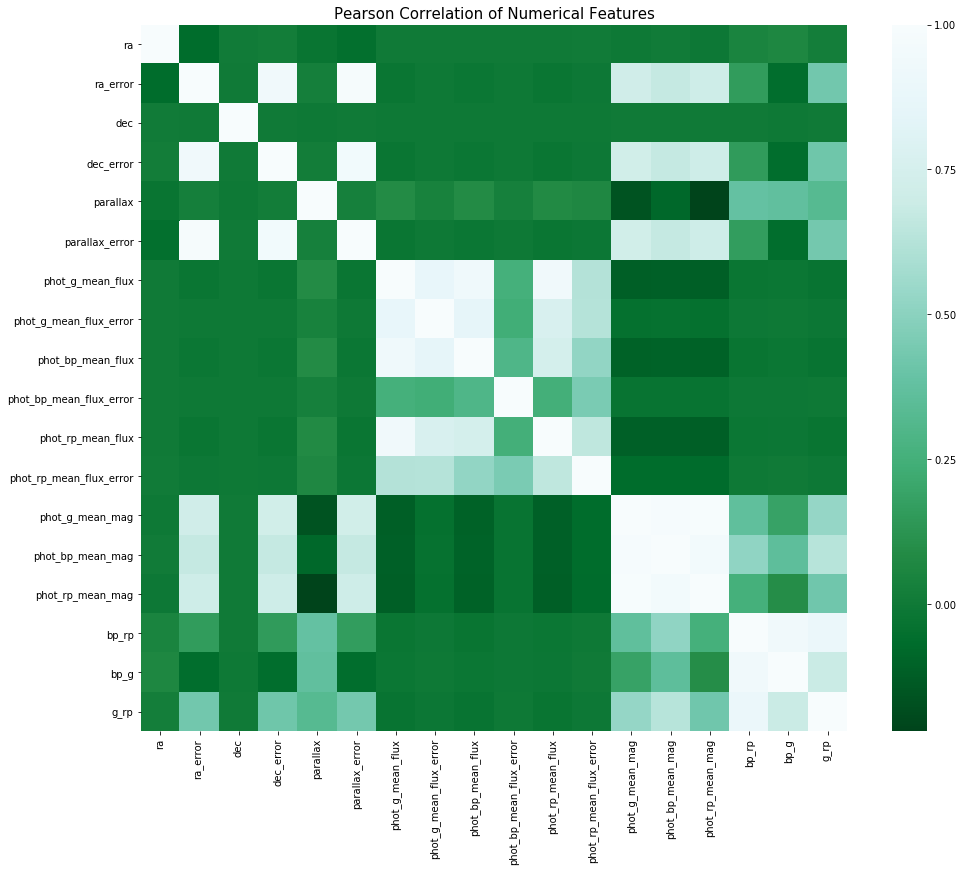

In [13]:
#Pearson Hotmap
import matplotlib.pyplot as plt
import seaborn as sns

features_numerical = ['ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error', 'phot_g_mean_flux',
                    'phot_g_mean_flux_error', 'phot_bp_mean_flux', 'phot_bp_mean_flux_error', 'phot_rp_mean_flux',
                     'phot_rp_mean_flux_error','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag','bp_rp','bp_g','g_rp']
gaia_df[features_numerical].head()
plt.subplots(figsize=(16, 13))
sns.heatmap(gaia_df[features_numerical].corr(), vmax=1.0, square=True, cmap="BuGn_r")
plt.title("Pearson Correlation of Numerical Features", fontsize=15)
plt.show()

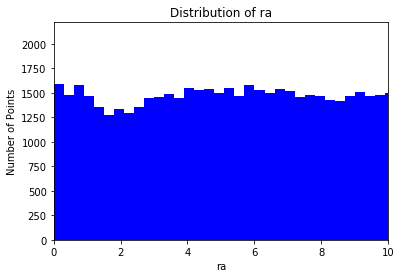

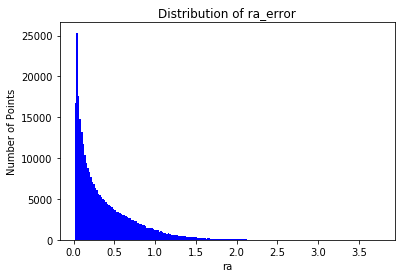

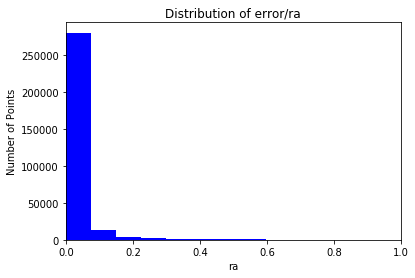

In [0]:
#distributin of ra
#num_bins = 20000
#n, bins, patches = plt.hist(acc[0], num_bins, facecolor='blue', alpha=0.5)
#plt.xlim(-2, 2)
#plt.show()
np_ra = np.array(gaia_df.loc[:,['ra']])
num_bins = 200
n, bins, patches = plt.hist(np_ra, num_bins, facecolor='blue', alpha=1)
plt.xlabel('ra')
plt.ylabel('Number of Points')
plt.title(r'Distribution of ra')
plt.xlim(0, 10)
#plt.xlim(-2, 2)
plt.show()

#distribution of ra error
np_ra_error = np.array(gaia_df.loc[:,['ra_error']])
num_bins = 200
n, bins, patches = plt.hist(np_ra_error, num_bins, facecolor='blue', alpha=1)
plt.xlabel('ra')
plt.ylabel('Number of Points')
plt.title(r'Distribution of ra_error')
#plt.xlim(-2, 2)
plt.show()

#distribution of ra_error/ra

num_bins = 20000
n, bins, patches = plt.hist(np_ra_error/np_ra, num_bins, facecolor='blue', alpha=1)
plt.xlabel('ra')
plt.ylabel('Number of Points')
plt.title(r'Distribution of error/ra')
plt.xlim(0, 1)
plt.show()

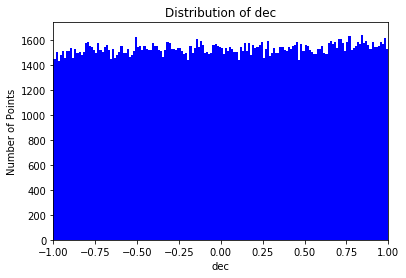

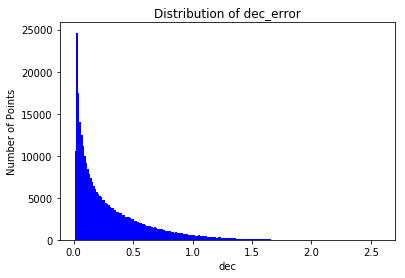

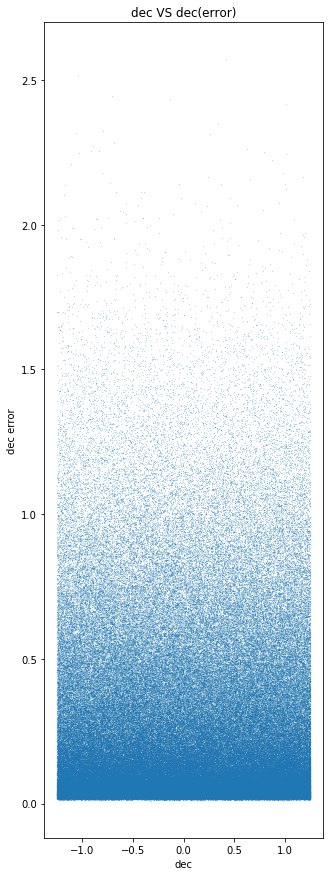

In [0]:
#distributin of dec
#num_bins = 20000
#n, bins, patches = plt.hist(acc[0], num_bins, facecolor='blue', alpha=0.5)
#plt.xlim(-2, 2)
#plt.show()
np_dec = np.array(gaia_df.loc[:,['dec']])
num_bins = 200
n, bins, patches = plt.hist(np_dec, num_bins, facecolor='blue', alpha=1)
plt.xlabel('dec')
plt.ylabel('Number of Points')
plt.title(r'Distribution of dec')
plt.xlim(-1, 1)
#plt.xlim(-2, 2)
plt.show()

#distribution of dec error
np_dec_error = np.array(gaia_df.loc[:,['dec_error']])
num_bins = 200
n, bins, patches = plt.hist(np_dec_error, num_bins, facecolor='blue', alpha=1)
plt.xlabel('dec')
plt.ylabel('Number of Points')
plt.title(r'Distribution of dec_error')
#plt.xlim(-2, 2)
plt.show()

#distribution of dec_error/dec

np_dec_error = np.array(gaia_df.loc[:,['dec_error']])
np_dec= np.array(gaia_df.loc[:,['dec']])
plt.figure(figsize=(5,15)) 
plt.scatter(np_dec, np_dec_error, s=0.01)
plt.xlabel('dec')
plt.ylabel('dec error')
plt.title(r'dec VS dec(error)')
plt.show()

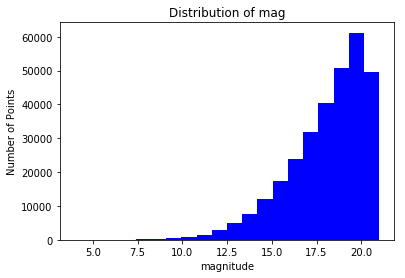

In [0]:
# distribution of 'phot_g_mean_mag'
np_dec = np.array(gaia_df.loc[:,['phot_g_mean_mag']])
num_bins = 20
n, bins, patches = plt.hist(np_dec, num_bins, facecolor='blue', alpha=1)
plt.xlabel('magnitude')
plt.ylabel('Number of Points')
plt.title(r'Distribution of mag')
#plt.xlim(-1, 1)

plt.show()


/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


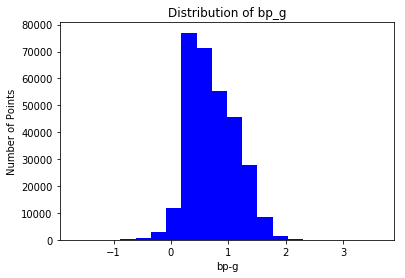

In [0]:
# Distribution of bp-g
np_bp_g = np.array(gaia_df.loc[:,['bp_g']])
num_bins = 20
n, bins, patches = plt.hist(np_bp_g, num_bins, facecolor='blue', alpha=1)
plt.xlabel('bp-g')
plt.ylabel('Number of Points')
plt.title(r'Distribution of bp_g')
#plt.xlim(-1, 1)

plt.show()


/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


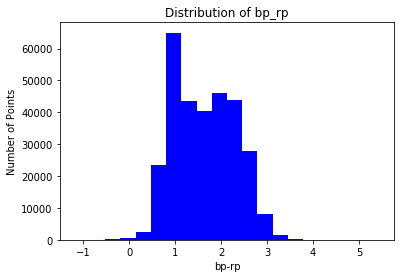

In [0]:
# Distribution of bp_rp
np_bp_rp = np.array(gaia_df.loc[:,['bp_rp']])
num_bins = 20
n, bins, patches = plt.hist(np_bp_rp, num_bins, facecolor='blue', alpha=1)
plt.xlabel('bp-rp')
plt.ylabel('Number of Points')
plt.title(r'Distribution of bp_rp')
#plt.xlim(-1, 1)

plt.show()

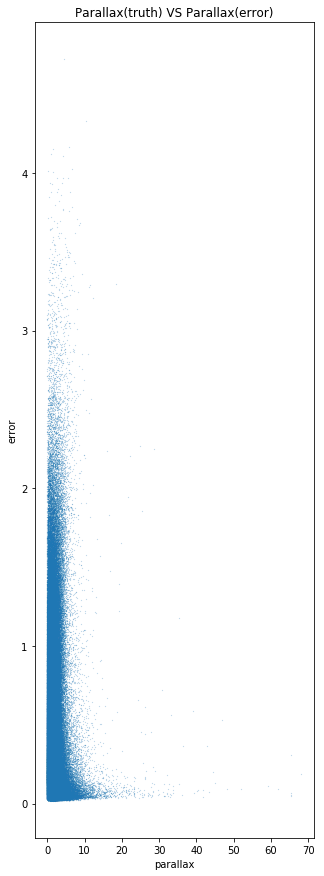

In [0]:
#relation between parallax(error) and parallax
np_parallax = np.array(gaia_df.loc[:,['parallax']])
np_parallax_error = np.array(gaia_df.loc[:,['parallax_error']])
plt.figure(figsize=(5,15)) 
plt.scatter(np_parallax, np_parallax_error, s=0.01)
plt.xlabel('parallax')
plt.ylabel('error')
plt.title(r'Parallax(truth) VS Parallax(error)')
plt.show()

### **Data processsing**

In [0]:
#select g, bp-g, bp-rp
new_df = gaia_selected.loc[:, ['ra', 'dec','phot_g_mean_mag', 'bp_g', 'bp_rp', 'parallax']]
new_df = new_df.dropna() #drop rows with nah

x_df = new_df.loc[:,['ra', 'dec','phot_g_mean_mag', 'bp_g', 'bp_rp']]
y_df = new_df.loc[:,['parallax']]

#split into train and validation
ratio = 0.95 #the ratio is train/all 
msk = np.random.rand(len(x_df)) < ratio
train_x = x_df[msk]
train_y = y_df[msk]
test_x = x_df[~msk]
test_y = y_df[~msk]

train_x = np.array(train_x).astype(float)
train_y = np.array(train_y).astype(float)
test_x = np.array(test_x).astype(float)
test_y = np.array(test_y).astype(float)

#locations = np.random.choice(train_x.shape[0],
                                 #size=20000,
                                 #replace=False)

#r_scaler = preprocessing.RobustScaler()
#train_norm_x = Normalization(train_x)[locations,:]
train_norm_x = Normalization(train_x)
#train_norm_y = Normalization(train_y)[locations,:]
train_norm_y = Normalization(train_y)
#train_norm_y = r_scaler.fit_transform(train_y)
test_norm_x = Normalization(test_x)
test_norm_y = Normalization(test_y)
#test_norm_y = r_scaler.fit_transform(test_y)


### **Main**

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
The accuracy is .....
-0.5144664


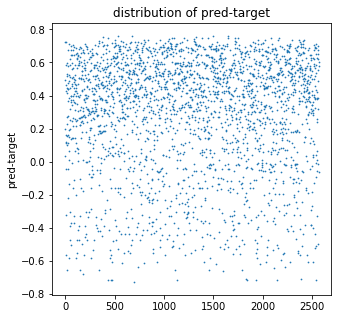

Iteration: 0, loss: 0.8588458895683289
The accuracy is .....
0.66107


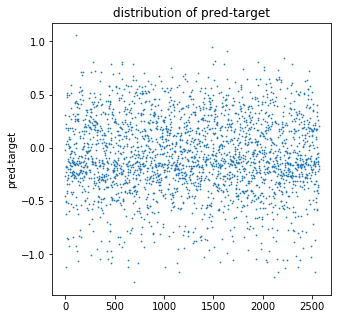

Iteration: 200, loss: 0.0529363788664341
The accuracy is .....
0.7472498


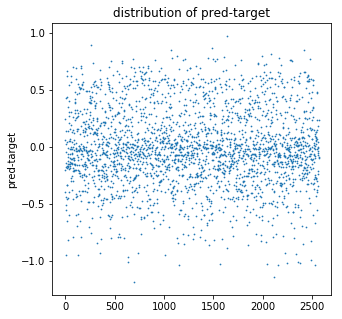

Iteration: 400, loss: -0.3533887267112732
The accuracy is .....
0.81586975


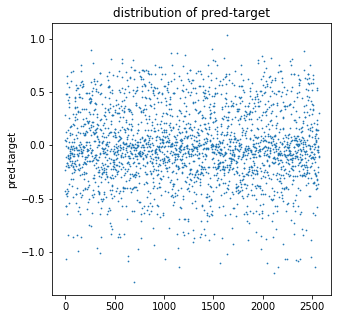

Iteration: 600, loss: -0.3977352976799011
The accuracy is .....
0.82335687


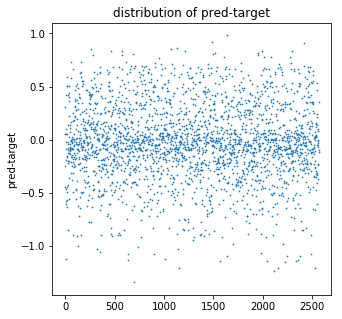

Iteration: 800, loss: -0.417850136756897
The accuracy is .....
0.81110233


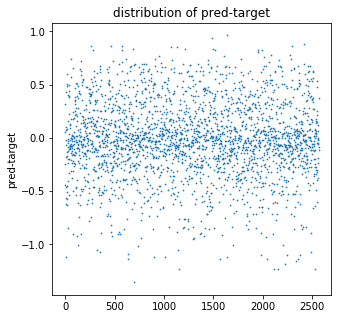

Iteration: 1000, loss: -0.43630096316337585
The accuracy is .....
0.7996014


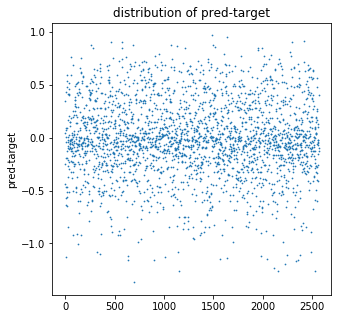

Iteration: 1200, loss: -0.4467998743057251
The accuracy is .....
0.79647887


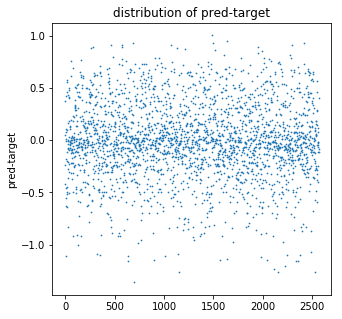

Iteration: 1400, loss: -0.45406997203826904
The accuracy is .....
0.79633343


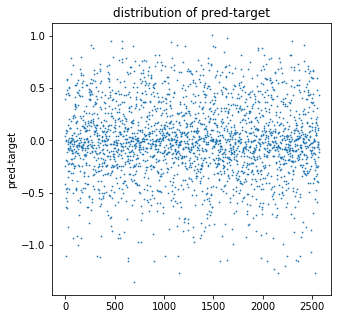

Iteration: 1600, loss: -0.4601052701473236
The accuracy is .....
0.81043816


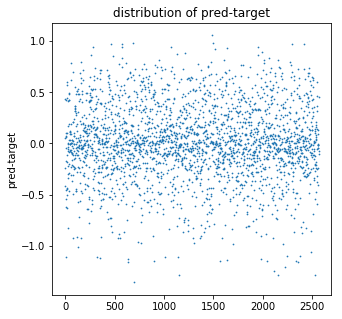

Iteration: 1800, loss: -0.4657077491283417
The accuracy is .....
0.7977561


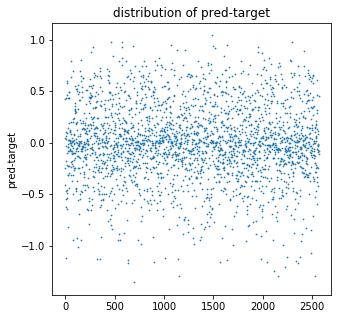

Iteration: 2000, loss: -0.4670397937297821
The accuracy is .....
0.80534005


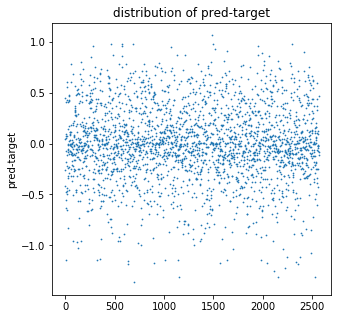

Iteration: 2200, loss: -0.4745735228061676
The accuracy is .....
0.7819348


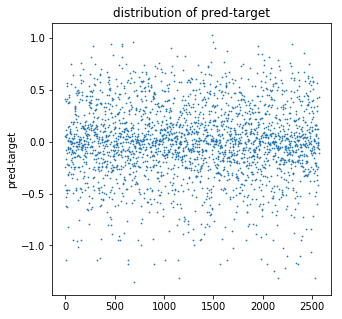

Iteration: 2400, loss: -0.47610530257225037
The accuracy is .....
0.8024936


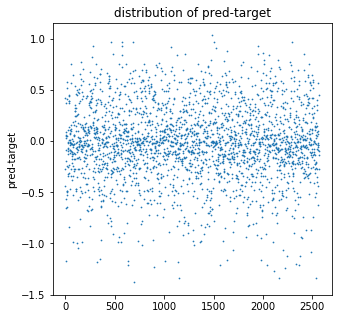

Iteration: 2600, loss: -0.4812338650226593
The accuracy is .....
0.78820807


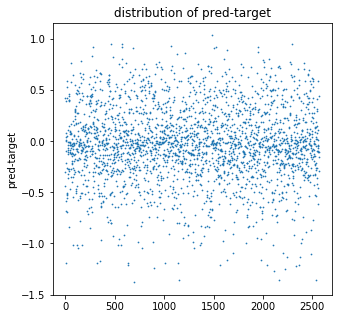

Iteration: 2800, loss: -0.4835054278373718
The accuracy is .....
0.77288264


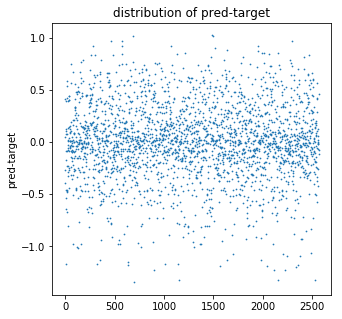

Iteration: 3000, loss: -0.4837818741798401
The accuracy is .....
0.79634315


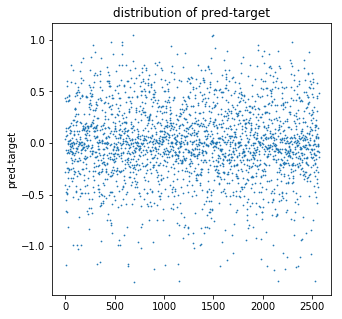

Iteration: 3200, loss: -0.48959121108055115
The accuracy is .....
0.77035195


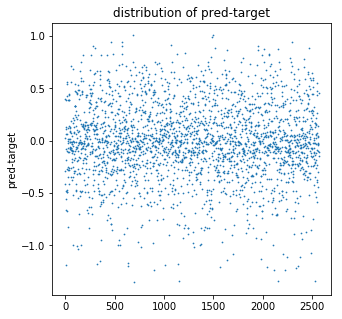

Iteration: 3400, loss: -0.4976762533187866
The accuracy is .....
0.7701909


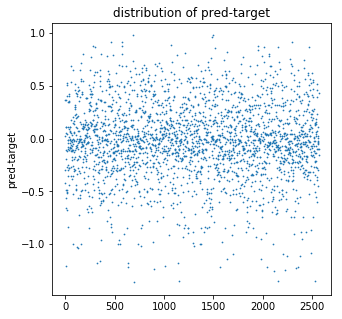

Iteration: 3600, loss: -0.5021054744720459
The accuracy is .....
0.78942686


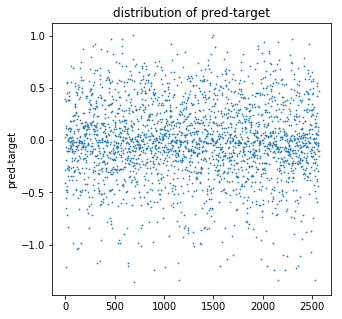

Iteration: 3800, loss: -0.5069290995597839
The accuracy is .....
0.77656513


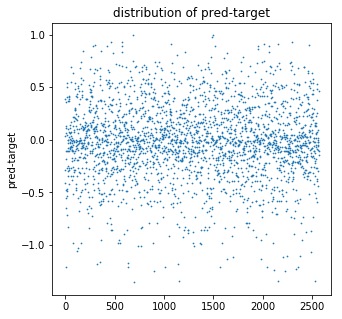

Iteration: 4000, loss: -0.5119619369506836
The accuracy is .....
0.7321181


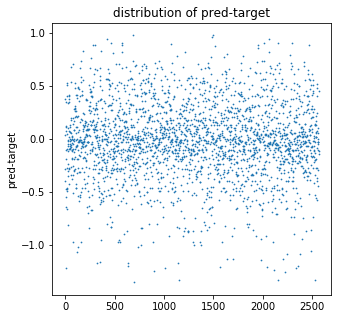

Iteration: 4200, loss: -0.5158739686012268
The accuracy is .....
0.7057707


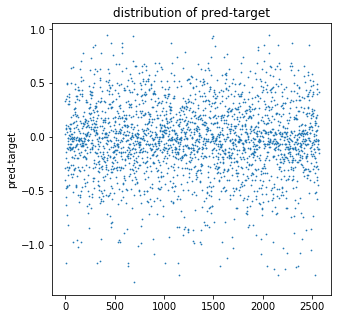

Iteration: 4400, loss: -0.5197187662124634
The accuracy is .....
0.70047504


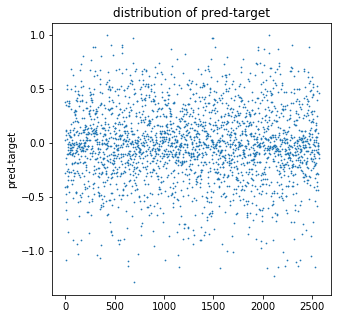

Iteration: 4600, loss: -0.5238310098648071
The accuracy is .....
0.6794162


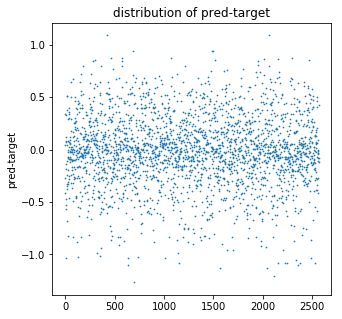

Iteration: 4800, loss: -0.5257886648178101
The accuracy is .....
0.676979


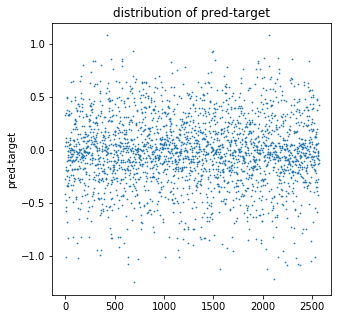

Iteration: 5000, loss: -0.5306630730628967
The accuracy is .....
0.65872395


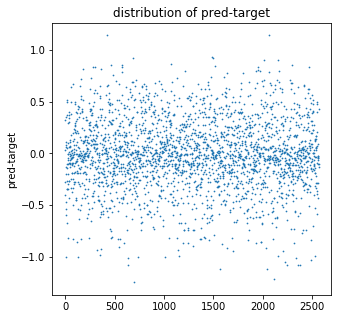

Iteration: 5200, loss: -0.5343242883682251
The accuracy is .....
0.74655724


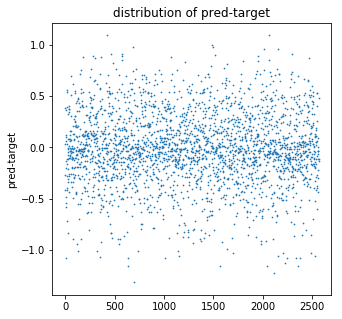

Iteration: 5400, loss: -0.537554919719696
The accuracy is .....
0.6995154


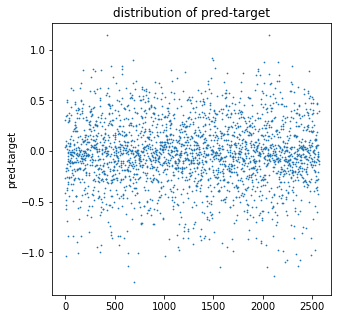

Iteration: 5600, loss: -0.5397469997406006
The accuracy is .....
0.6927155


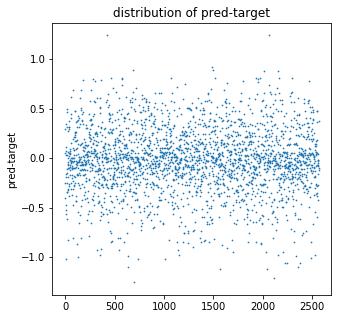

Iteration: 5800, loss: -0.5440148115158081
The accuracy is .....
0.67033


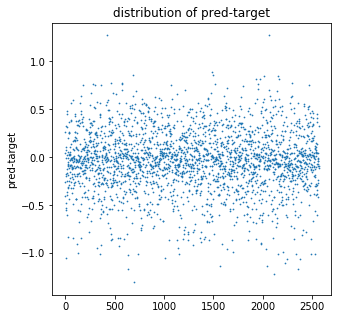

Iteration: 6000, loss: -0.5463272929191589
The accuracy is .....
0.64251745


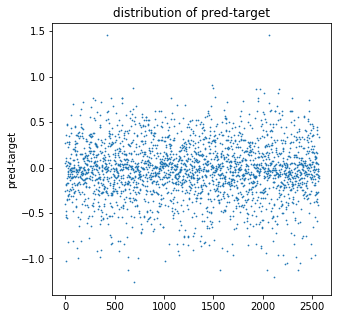

Iteration: 6200, loss: -0.5513955950737
The accuracy is .....
0.5842119


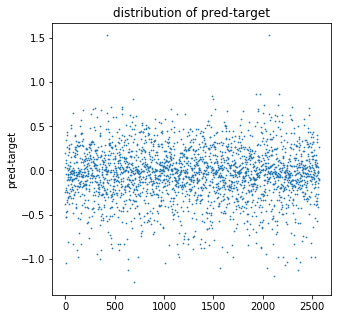

Iteration: 6400, loss: -0.5561167001724243
The accuracy is .....
0.53459114


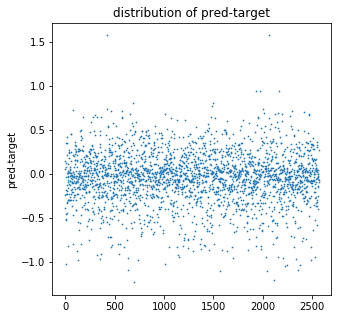

Iteration: 6600, loss: -0.561123251914978
The accuracy is .....
0.39370868


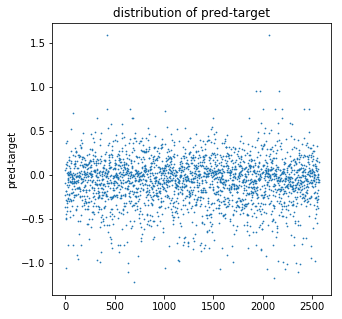

Iteration: 6800, loss: -0.5694530010223389
The accuracy is .....
0.3714437


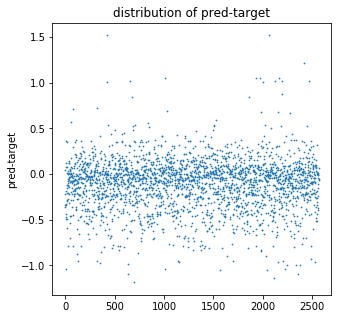

Iteration: 7000, loss: -0.5826945304870605
The accuracy is .....
0.47532904


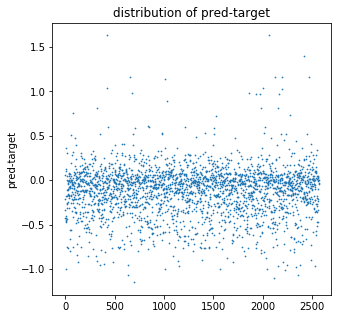

Iteration: 7200, loss: -0.594021737575531
The accuracy is .....
0.5906028


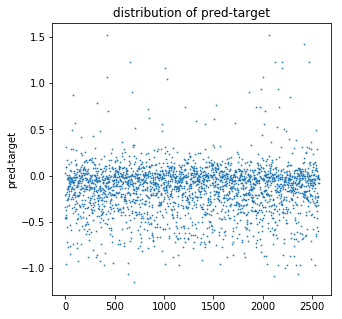

Iteration: 7400, loss: -0.6213178038597107
The accuracy is .....
0.5304725


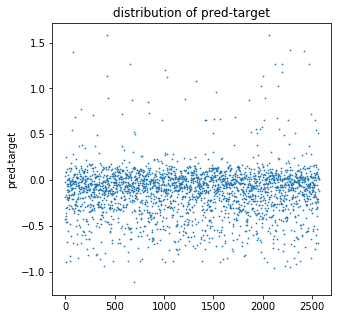

Iteration: 7600, loss: -0.6656004190444946
The accuracy is .....
0.28968108


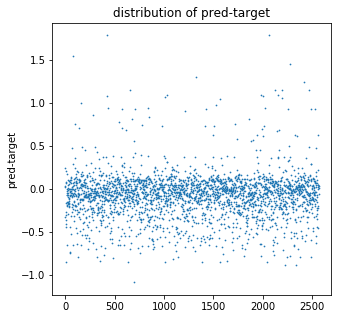

Iteration: 7800, loss: -0.7068310976028442
The accuracy is .....
0.17998618


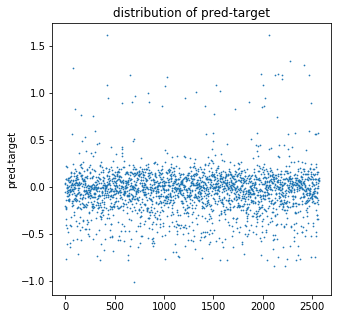

Iteration: 8000, loss: -0.798129677772522
The accuracy is .....
0.1997911


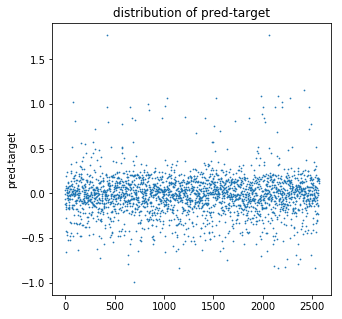

Iteration: 8200, loss: -0.9736983180046082
The accuracy is .....
0.31641


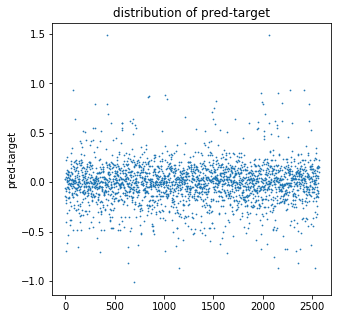

Iteration: 8400, loss: -1.1250492334365845
The accuracy is .....
0.3618298


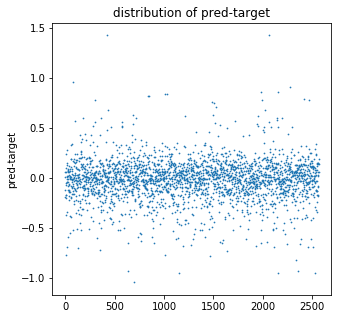

Iteration: 8600, loss: -1.210173487663269
The accuracy is .....
0.32207593


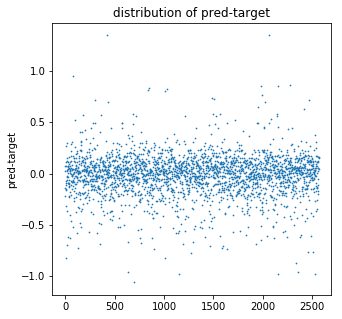

Iteration: 8800, loss: -1.2549901008605957
The accuracy is .....
0.3227534


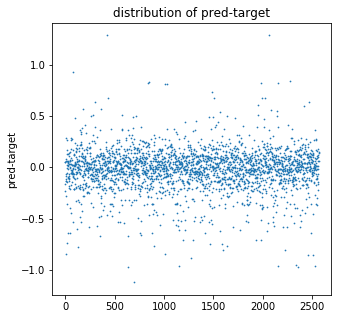

Iteration: 9000, loss: -1.2814682722091675
The accuracy is .....
0.34149867


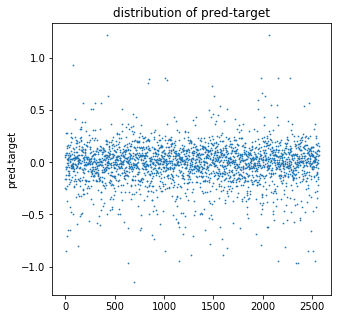

Iteration: 9200, loss: -1.298684000968933
The accuracy is .....
0.3363979


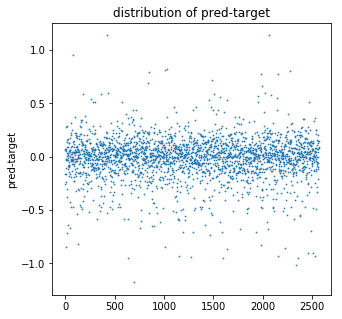

Iteration: 9400, loss: -1.3112810850143433
The accuracy is .....
0.30476105


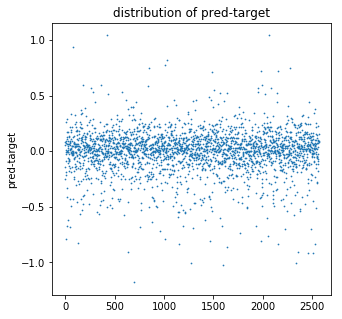

Iteration: 9600, loss: -1.3159722089767456
The accuracy is .....
0.2860343


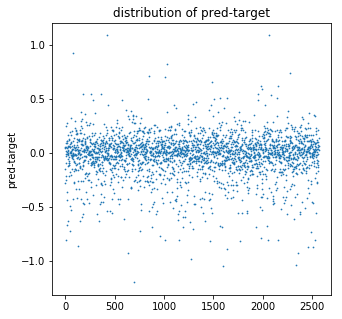

Iteration: 9800, loss: -1.3279175758361816
The accuracy is .....
0.30365908


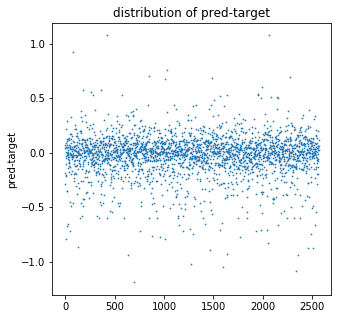

Iteration: 10000, loss: -1.3332351446151733
The accuracy is .....
0.2815596


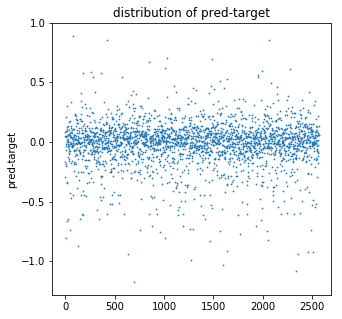

Iteration: 10200, loss: -1.3384393453598022
The accuracy is .....
0.23928323


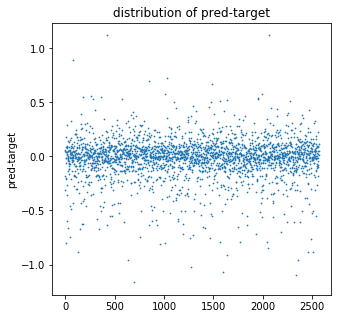

Iteration: 10400, loss: -1.3419045209884644
The accuracy is .....
0.2607218


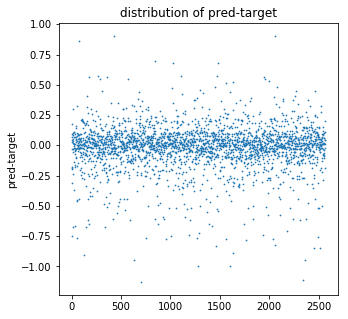

Iteration: 10600, loss: -1.3463306427001953
The accuracy is .....
0.21628971


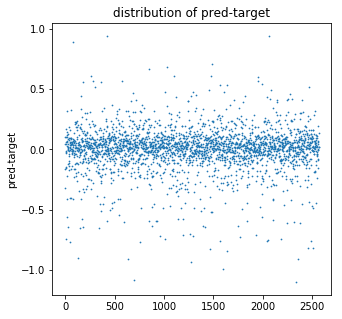

Iteration: 10800, loss: -1.3464868068695068
The accuracy is .....
0.24103948


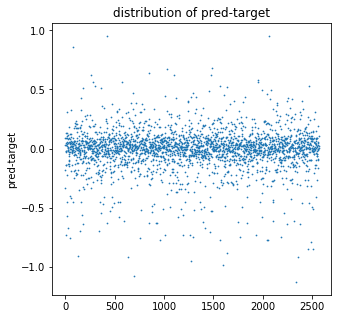

Iteration: 11000, loss: -1.3518427610397339
The accuracy is .....
0.16114236


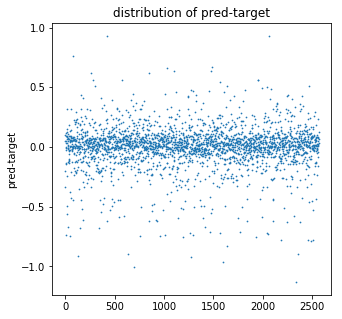

Iteration: 11200, loss: -1.3539013862609863
The accuracy is .....
0.19921209


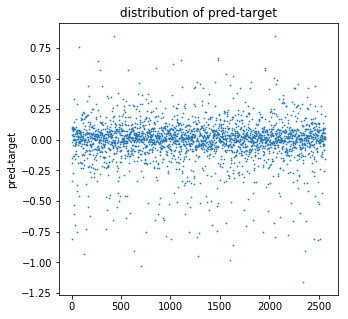

Iteration: 11400, loss: -1.3563814163208008
The accuracy is .....
0.15292345


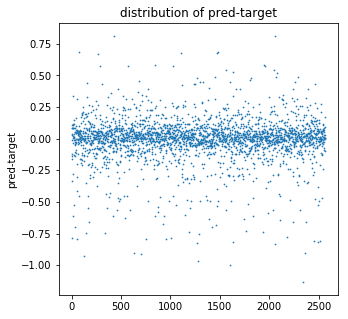

Iteration: 11600, loss: -1.3584874868392944
The accuracy is .....
0.15321597


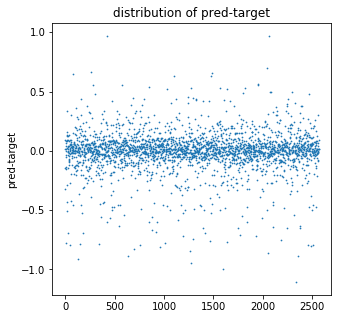

Iteration: 11800, loss: -1.3599469661712646
The accuracy is .....
0.10936522


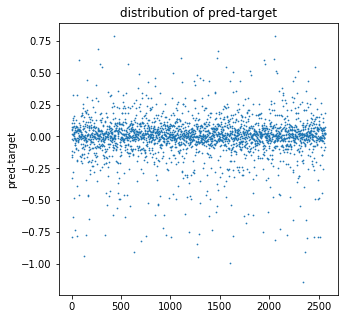

Iteration: 12000, loss: -1.3618367910385132
The accuracy is .....
0.12130603


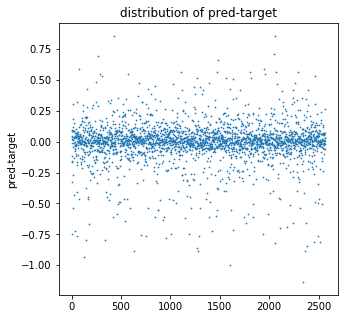

Iteration: 12200, loss: -1.362840175628662
The accuracy is .....
0.052391887


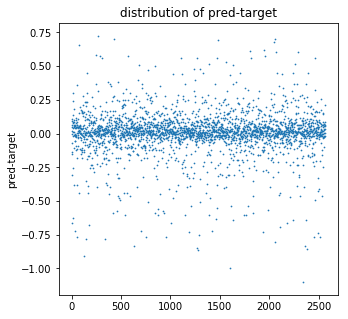

Iteration: 12400, loss: -1.364395022392273
The accuracy is .....
0.08981396


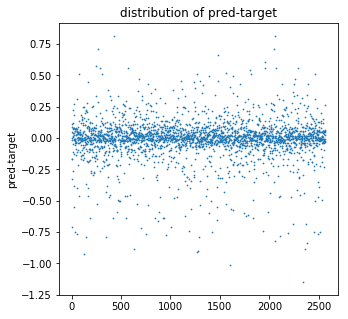

Iteration: 12600, loss: -1.363531231880188
The accuracy is .....
0.09880614


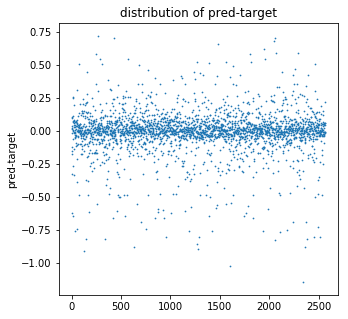

Iteration: 12800, loss: -1.3654239177703857
The accuracy is .....
0.07733253


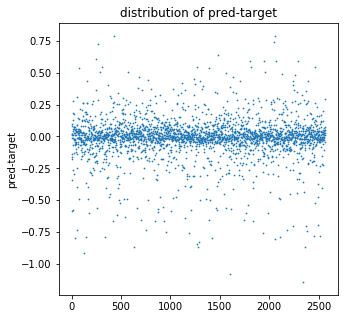

Iteration: 13000, loss: -1.353109359741211
The accuracy is .....
0.041379333


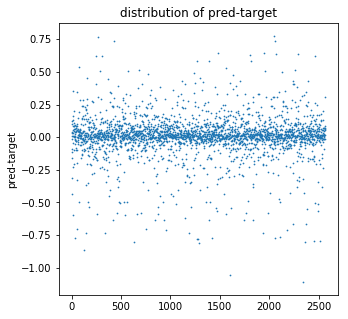

Iteration: 13200, loss: -1.368653655052185
The accuracy is .....
0.054756142


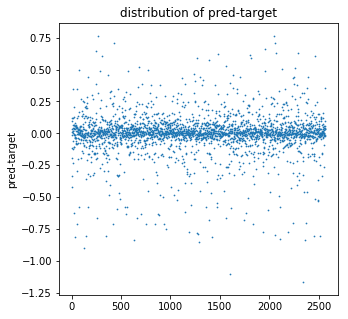

Iteration: 13400, loss: -1.367967963218689
The accuracy is .....
0.052766033


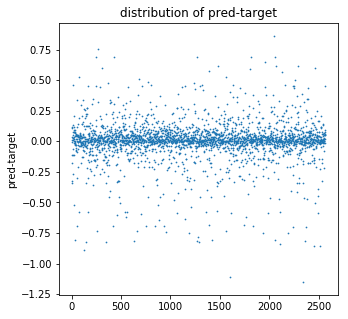

Iteration: 13600, loss: -1.370049238204956
The accuracy is .....
0.049985938


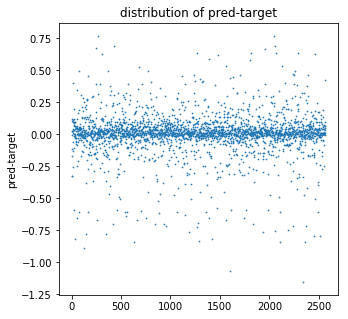

Iteration: 13800, loss: -1.3709043264389038
The accuracy is .....
0.03895555


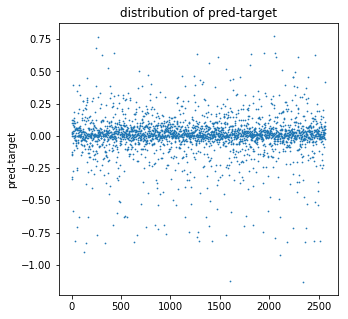

Iteration: 14000, loss: -1.3701714277267456
The accuracy is .....
0.023744715


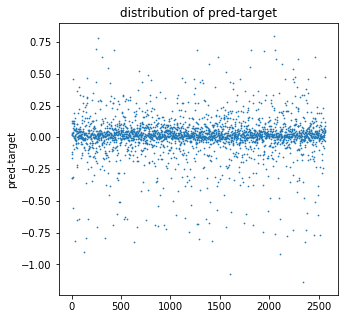

Iteration: 14200, loss: -1.3720629215240479
The accuracy is .....
0.065051265


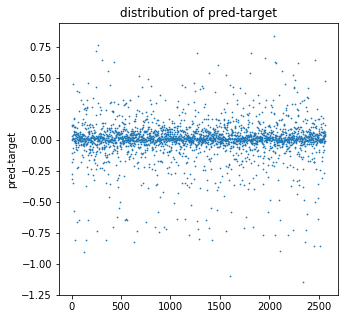

Iteration: 14400, loss: -1.3725374937057495
The accuracy is .....
0.040168807


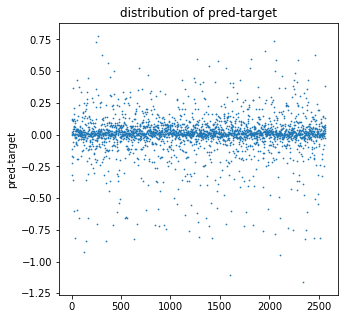

Iteration: 14600, loss: -1.3732131719589233
The accuracy is .....
0.05247289


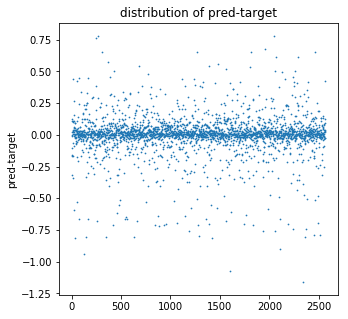

Iteration: 14800, loss: -1.3733134269714355
The accuracy is .....
0.04333005


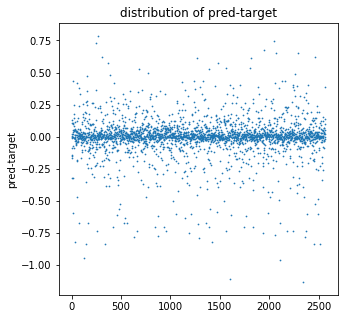

Iteration: 15000, loss: -1.3717397451400757
The accuracy is .....
0.04151137


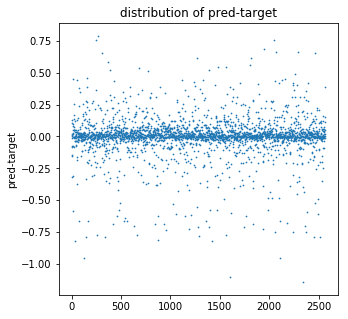

Iteration: 15200, loss: -1.373745322227478
The accuracy is .....
0.024613265


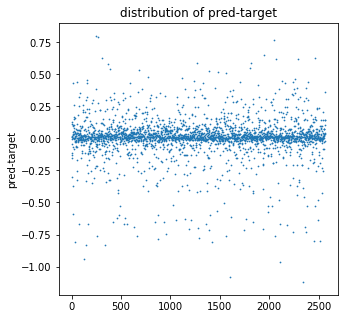

Iteration: 15400, loss: -1.3751001358032227
The accuracy is .....
0.056978885


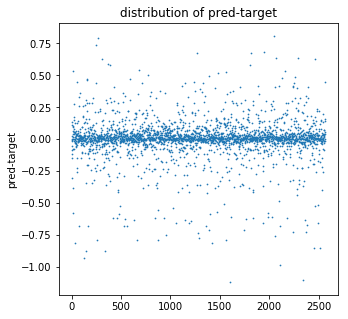

Iteration: 15600, loss: -1.3753671646118164
The accuracy is .....
0.032365847


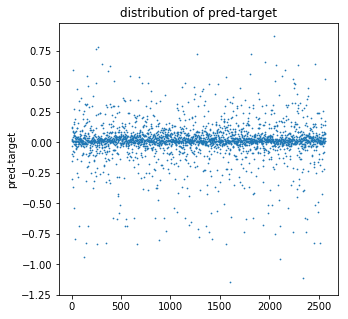

Iteration: 15800, loss: -1.3756153583526611
The accuracy is .....
0.060315676


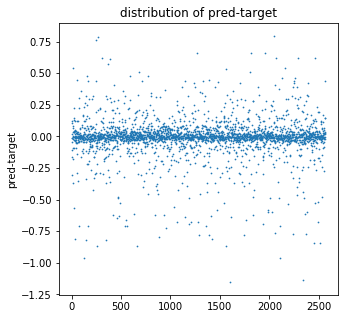

Iteration: 16000, loss: -1.3709676265716553
The accuracy is .....
0.049956765


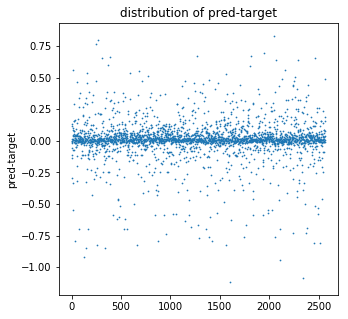

Iteration: 16200, loss: -1.376581072807312
The accuracy is .....
0.03717953


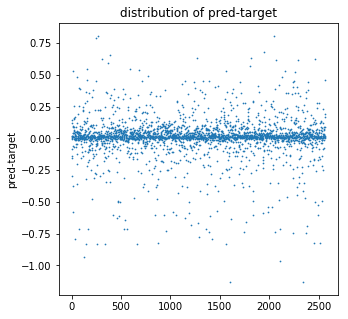

Iteration: 16400, loss: -1.375415563583374
The accuracy is .....
0.061787784


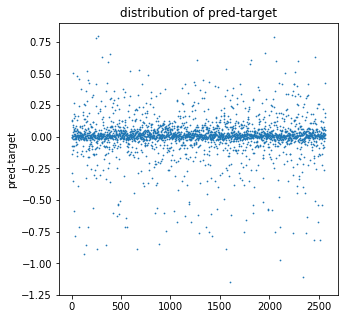

Iteration: 16600, loss: -1.377189040184021
The accuracy is .....
0.06975763


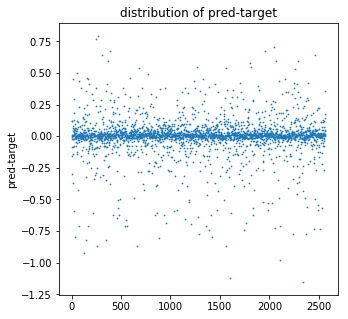

Iteration: 16800, loss: -1.3774950504302979
The accuracy is .....
0.04422638


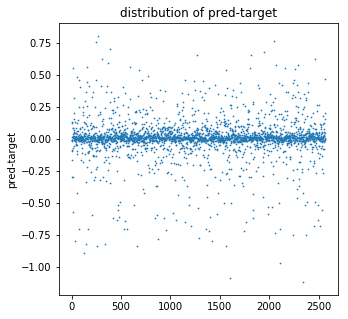

Iteration: 17000, loss: -1.377746343612671
The accuracy is .....
0.03649226


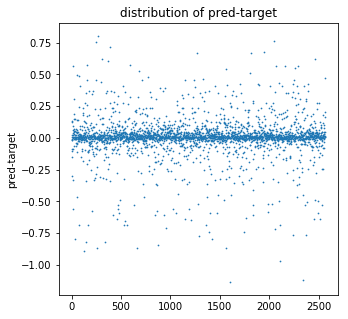

Iteration: 17200, loss: -1.3780310153961182
The accuracy is .....
0.019185012


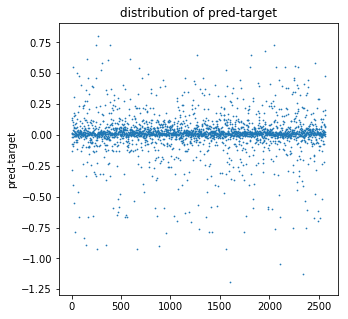

Iteration: 17400, loss: -1.3780407905578613
The accuracy is .....
0.0021863936


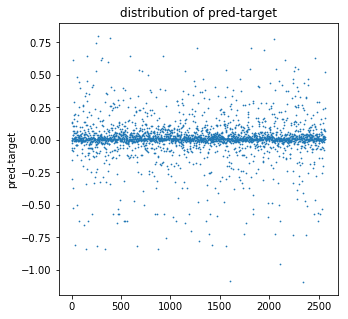

Iteration: 17600, loss: -1.3784185647964478
The accuracy is .....
0.0044848775


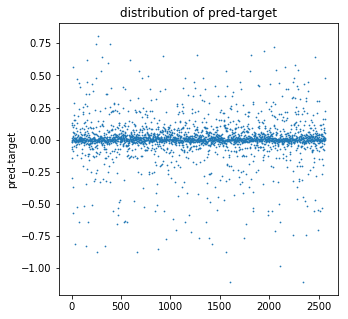

Iteration: 17800, loss: -1.3767037391662598
The accuracy is .....
0.015790392


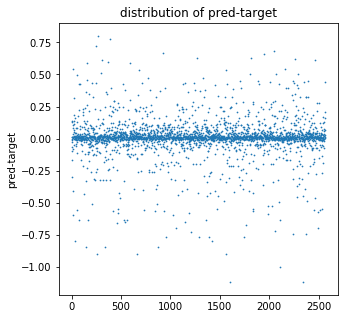

Iteration: 18000, loss: -1.3787893056869507
The accuracy is .....
0.011515464


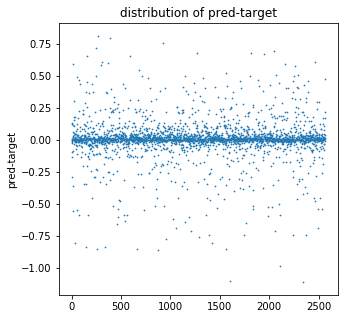

Iteration: 18200, loss: -1.3791033029556274
The accuracy is .....
0.013020431


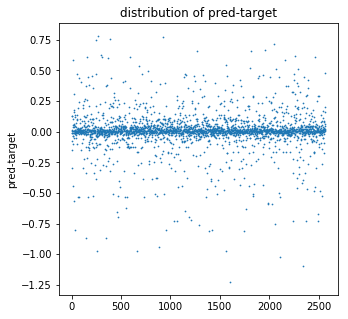

Iteration: 18400, loss: -1.3791978359222412
The accuracy is .....
0.011415393


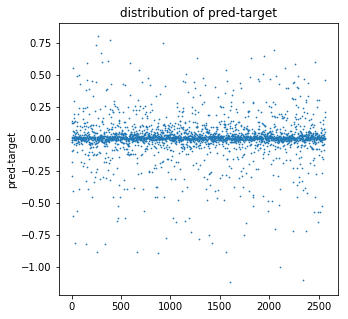

Iteration: 18600, loss: -1.379441738128662
The accuracy is .....
0.026447535


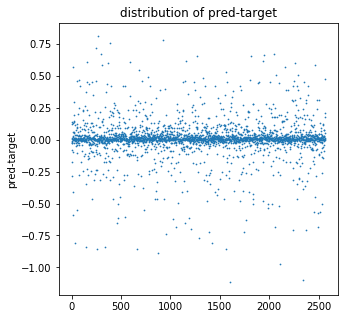

Iteration: 18800, loss: -1.379335641860962
The accuracy is .....
0.022111187


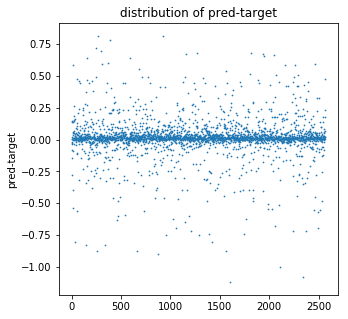

Iteration: 19000, loss: -1.3780936002731323
The accuracy is .....
0.020984128


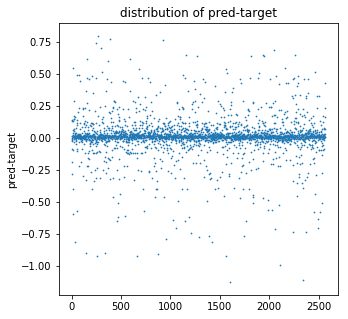

Iteration: 19200, loss: -1.3798463344573975
The accuracy is .....
0.029204318


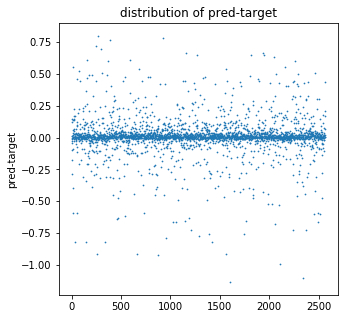

Iteration: 19400, loss: -1.37997305393219
The accuracy is .....
0.031303022


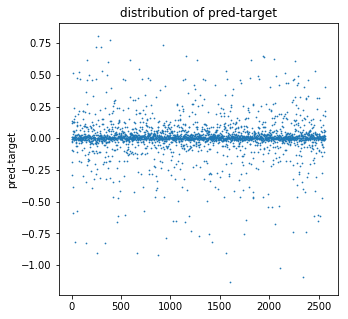

Iteration: 19600, loss: -1.3795610666275024
The accuracy is .....
0.039729577


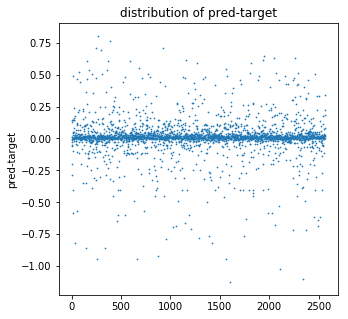

Iteration: 19800, loss: -1.3796991109848022
The accuracy is .....
0.03118893


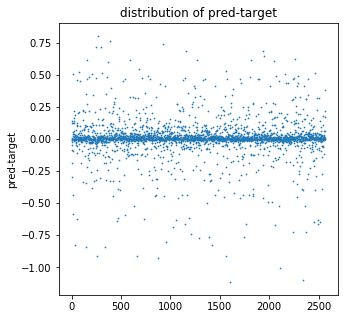

Iteration: 20000, loss: -1.3801740407943726
The accuracy is .....
0.056610495


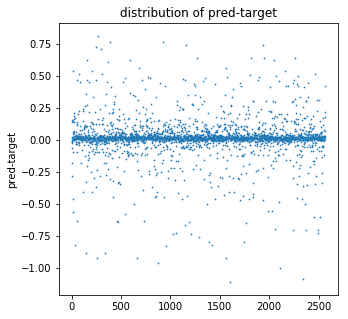

Iteration: 20200, loss: -1.3781253099441528
The accuracy is .....
0.046444945


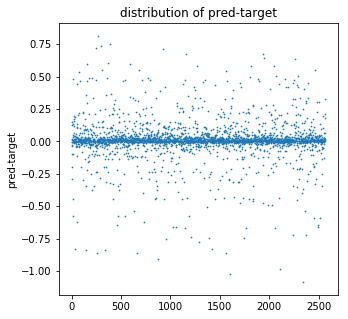

Iteration: 20400, loss: -1.380502462387085
The accuracy is .....
0.0647699


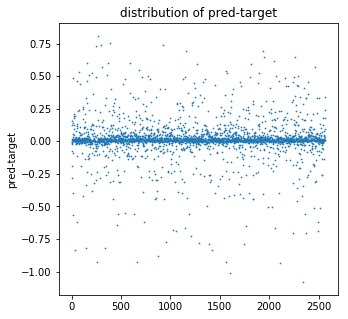

Iteration: 20600, loss: -1.3804229497909546
The accuracy is .....
0.03714672


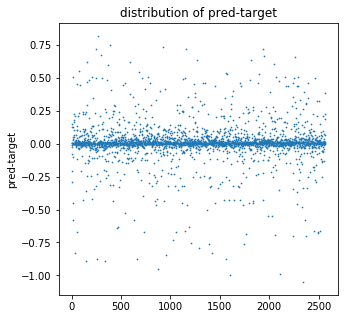

Iteration: 20800, loss: -1.380630373954773
The accuracy is .....
0.029255182


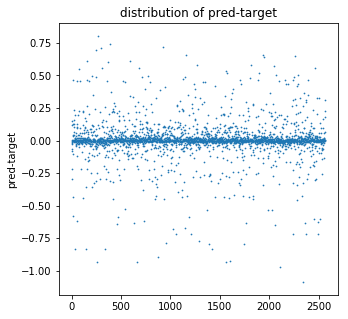

Iteration: 21000, loss: -1.3800652027130127
The accuracy is .....
0.030777043


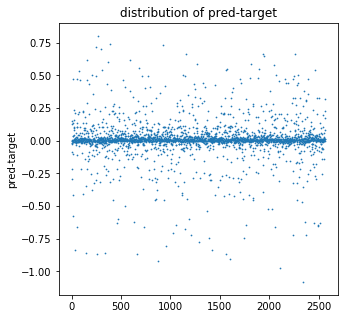

Iteration: 21200, loss: -1.3809080123901367
The accuracy is .....
0.041349046


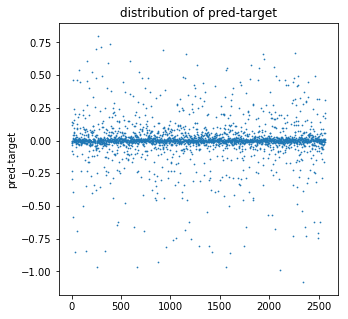

Iteration: 21400, loss: -1.3799517154693604
The accuracy is .....
0.009625481


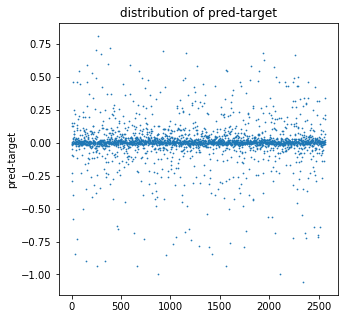

Iteration: 21600, loss: -1.380963921546936
The accuracy is .....
0.030700607


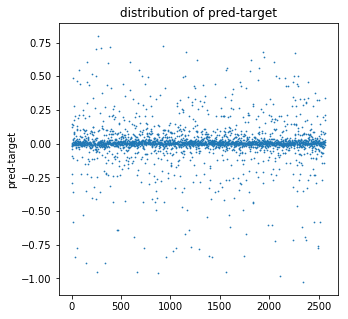

Iteration: 21800, loss: -1.3810192346572876
The accuracy is .....
0.01847742


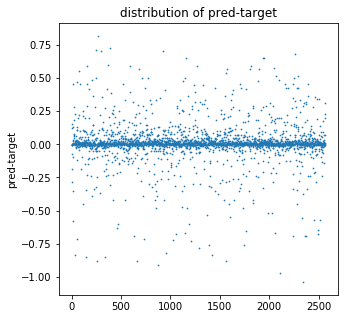

Iteration: 22000, loss: -1.3810696601867676
The accuracy is .....
0.028641654


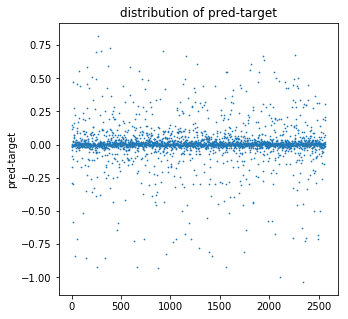

Iteration: 22200, loss: -1.3811471462249756
The accuracy is .....
0.028334977


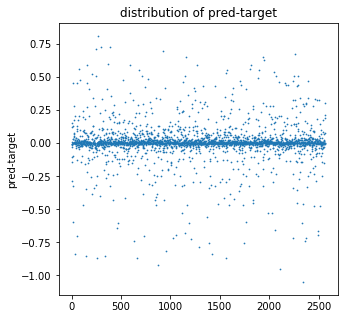

Iteration: 22400, loss: -1.3813753128051758
The accuracy is .....
0.021761749


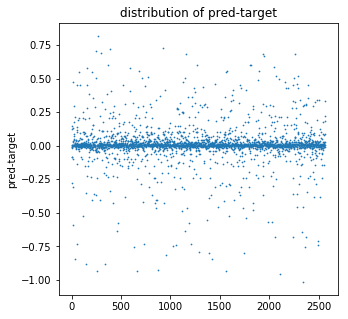

Iteration: 22600, loss: -1.3814030885696411
The accuracy is .....
0.005186758


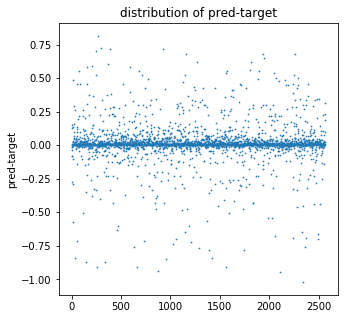

Iteration: 22800, loss: -1.3801994323730469
The accuracy is .....
0.006681905


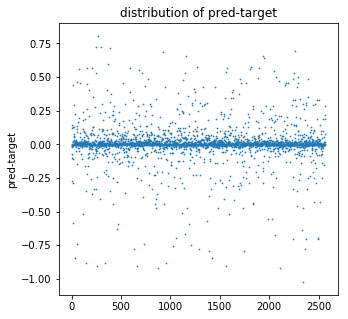

Iteration: 23000, loss: -1.3813514709472656
The accuracy is .....
0.03432649


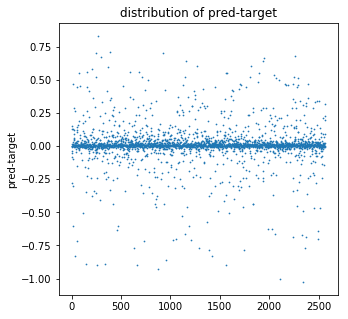

Iteration: 23200, loss: -1.3810372352600098
The accuracy is .....
0.050251704


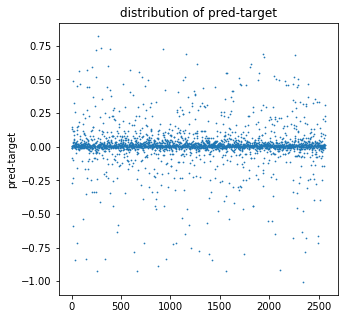

Iteration: 23400, loss: -1.3812934160232544
The accuracy is .....
0.0016170037


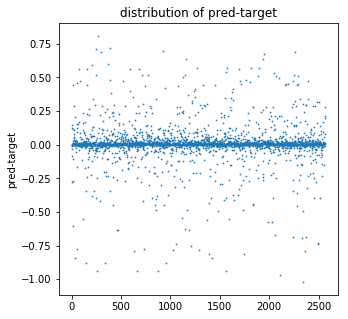

Iteration: 23600, loss: -1.381583571434021
The accuracy is .....
-0.029993499


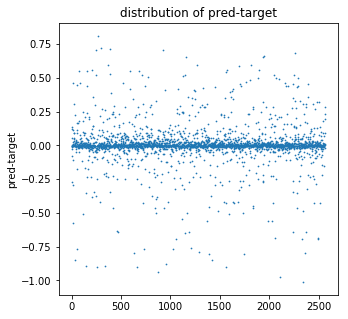

Iteration: 23800, loss: -1.3812206983566284
The accuracy is .....
-0.01975083


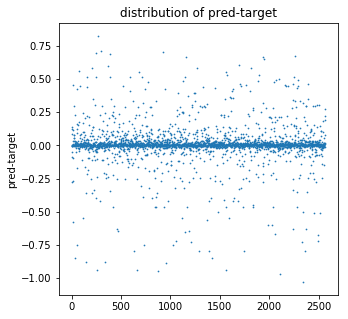

Iteration: 24000, loss: -1.3818104267120361
The accuracy is .....
-0.01367322


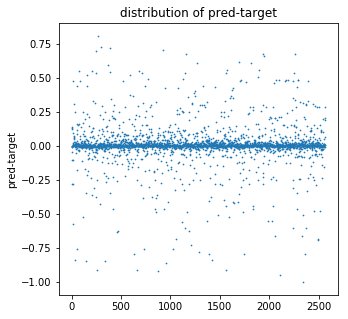

Iteration: 24200, loss: -1.3816975355148315
The accuracy is .....
-0.0033764127


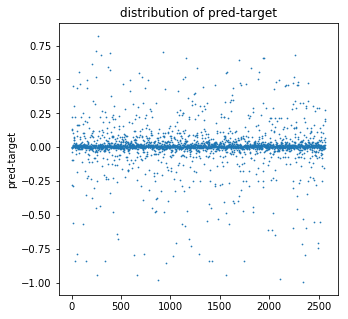

Iteration: 24400, loss: -1.3815562725067139
The accuracy is .....
0.0015312198


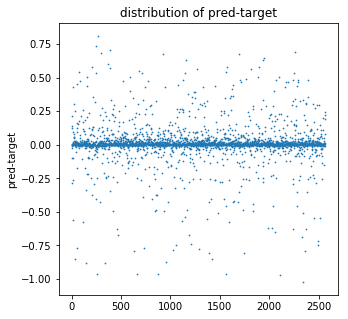

Iteration: 24600, loss: -1.3818551301956177
The accuracy is .....
-0.019260976


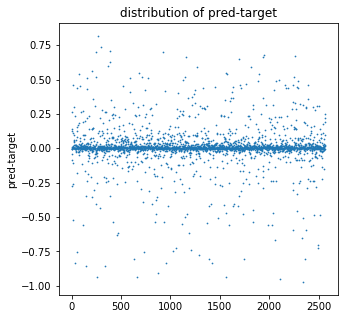

Iteration: 24800, loss: -1.3819735050201416
The accuracy is .....
-0.018887272


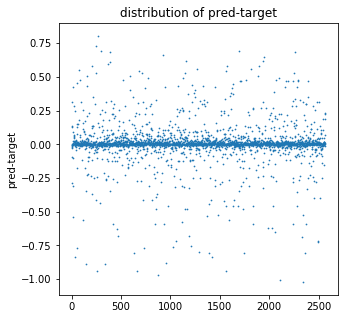

Iteration: 25000, loss: -1.3820335865020752
The accuracy is .....
-0.017138476


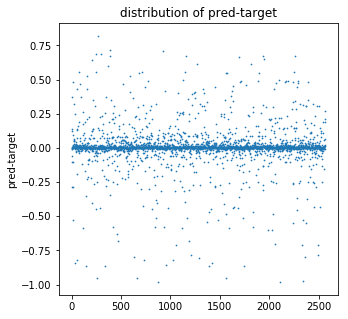

Iteration: 25200, loss: -1.3819845914840698
The accuracy is .....
-0.023069177


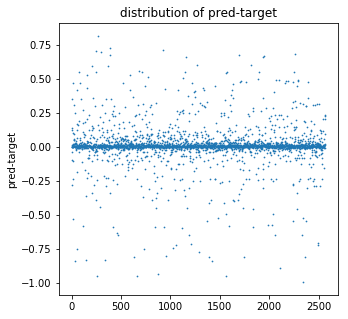

Iteration: 25400, loss: -1.382122278213501
The accuracy is .....
-0.043665495


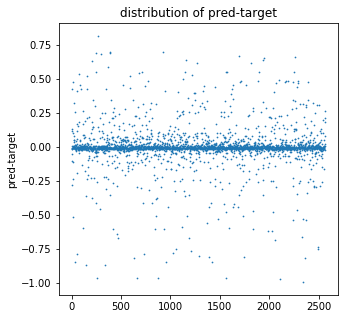

Iteration: 25600, loss: -1.3803327083587646
The accuracy is .....
-0.031003416


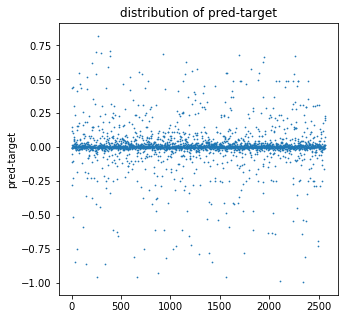

Iteration: 25800, loss: -1.3821927309036255
The accuracy is .....
-0.032217223


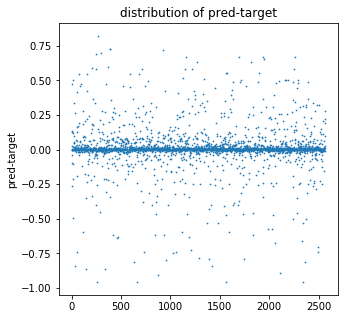

Iteration: 26000, loss: -1.3822147846221924
The accuracy is .....
-0.026137663


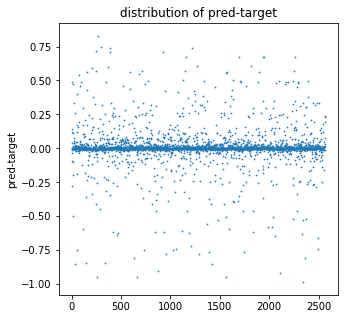

Iteration: 26200, loss: -1.3820809125900269
The accuracy is .....
-0.030010121


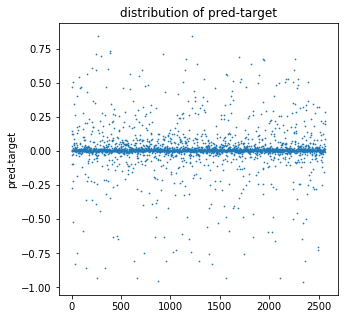

Iteration: 26400, loss: -1.3818070888519287
The accuracy is .....
-0.036093213


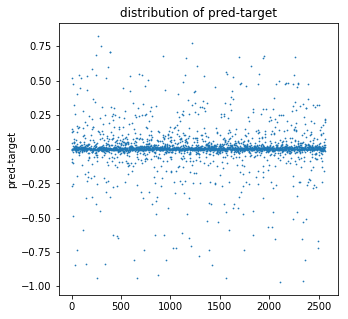

Iteration: 26600, loss: -1.3821791410446167
The accuracy is .....
-0.04886577


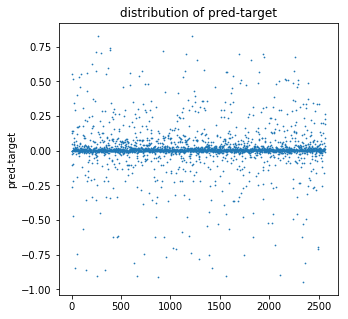

Iteration: 26800, loss: -1.382314682006836
The accuracy is .....
-0.04330717


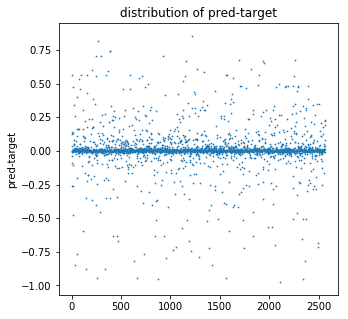

Iteration: 27000, loss: -1.3823782205581665
The accuracy is .....
-0.050655954


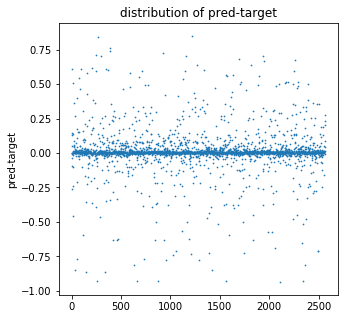

Iteration: 27200, loss: -1.3822280168533325
The accuracy is .....
-0.03656843


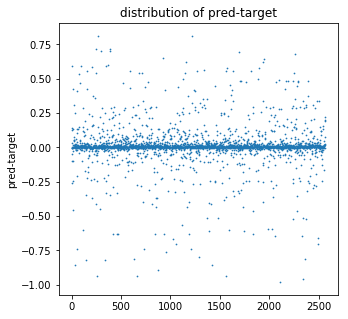

Iteration: 27400, loss: -1.3823153972625732
The accuracy is .....
-0.031848166


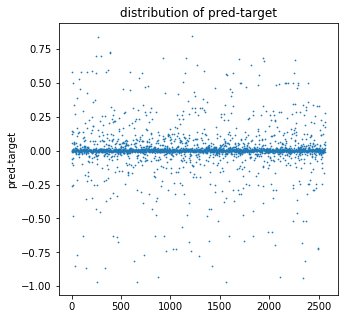

Iteration: 27600, loss: -1.382469892501831
The accuracy is .....
-0.02054054


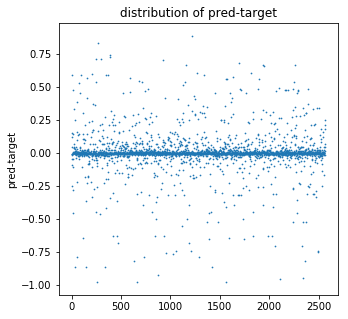

Iteration: 27800, loss: -1.3812875747680664
The accuracy is .....
-0.014993621


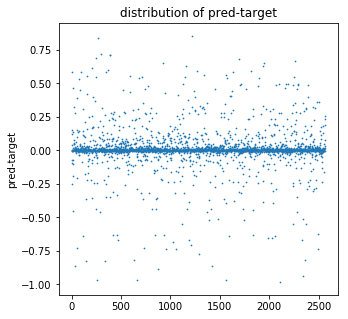

Iteration: 28000, loss: -1.382515549659729
The accuracy is .....
-0.018589621


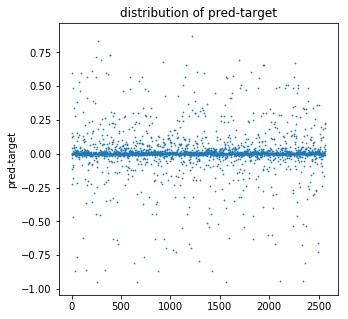

Iteration: 28200, loss: -1.3825395107269287
The accuracy is .....
-0.015764365


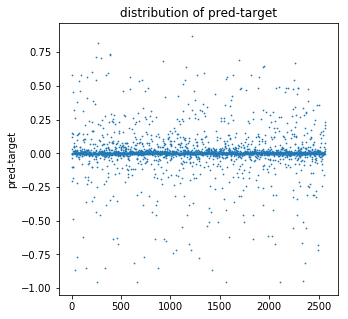

Iteration: 28400, loss: -1.3825347423553467
The accuracy is .....
0.0013127879


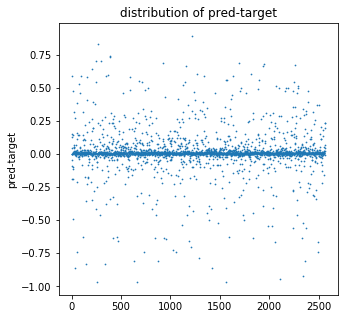

Iteration: 28600, loss: -1.3820644617080688
The accuracy is .....
0.020339353


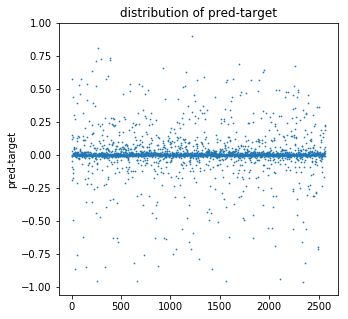

Iteration: 28800, loss: -1.3825201988220215
The accuracy is .....
0.0041483636


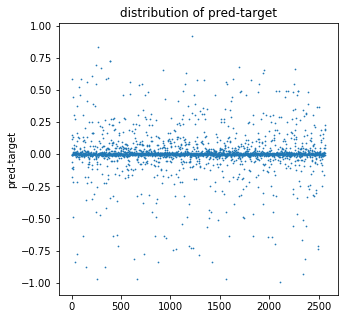

Iteration: 29000, loss: -1.382609248161316
The accuracy is .....
0.011649547


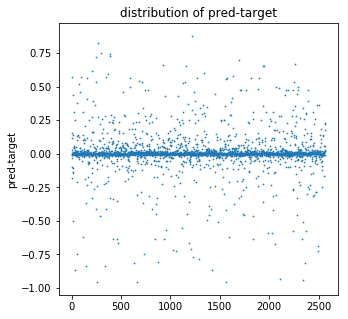

Iteration: 29200, loss: -1.3825428485870361
The accuracy is .....
0.019380353


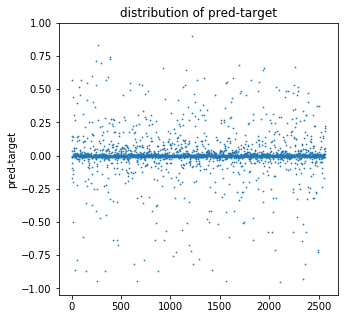

Iteration: 29400, loss: -1.3821253776550293
The accuracy is .....
0.011537318


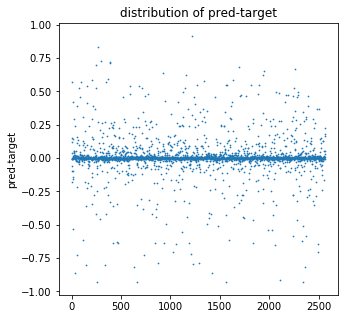

Iteration: 29600, loss: -1.3826736211776733
The accuracy is .....
0.0028921794


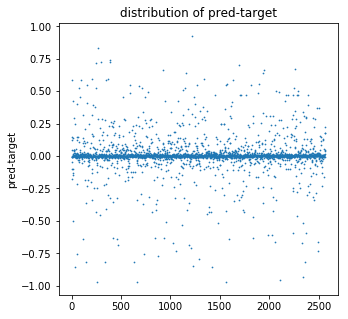

Iteration: 29800, loss: -1.3827073574066162
The accuracy is .....
0.009351997


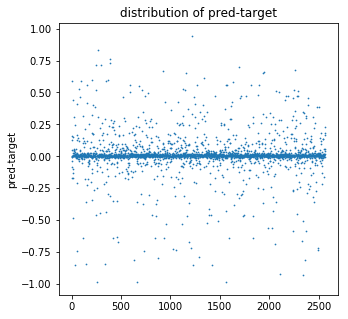

Iteration: 30000, loss: -1.3819776773452759
The accuracy is .....
0.041431624


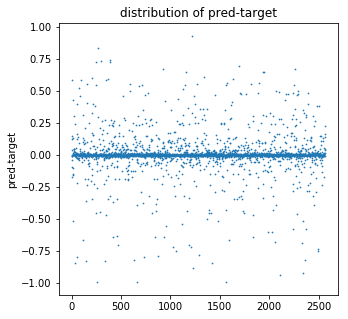

Iteration: 30200, loss: -1.382681131362915
The accuracy is .....
0.046027686


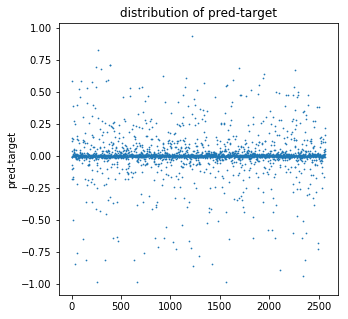

Iteration: 30400, loss: -1.3823823928833008
The accuracy is .....
0.030465573


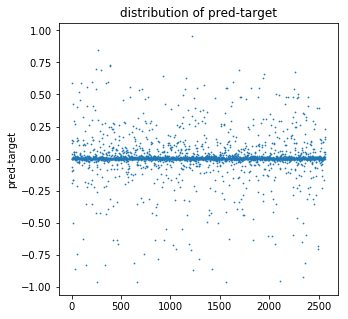

Iteration: 30600, loss: -1.382799506187439
The accuracy is .....
0.052229017


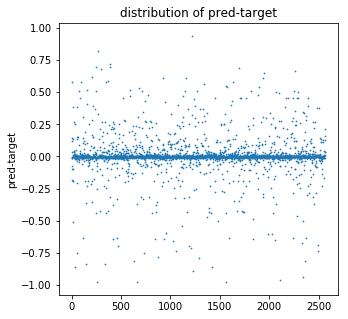

Iteration: 30800, loss: -1.3820401430130005
The accuracy is .....
0.039788652


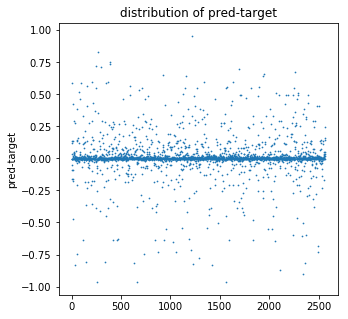

Iteration: 31000, loss: -1.3827050924301147
The accuracy is .....
0.03266872


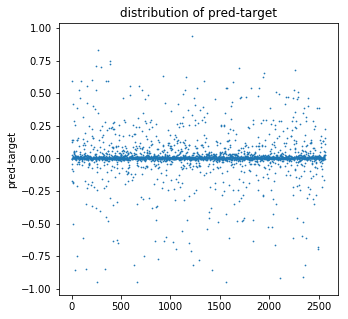

Iteration: 31200, loss: -1.3826135396957397
The accuracy is .....
0.055701554


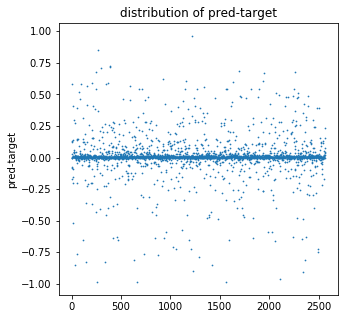

Iteration: 31400, loss: -1.3826313018798828
The accuracy is .....
0.048598725


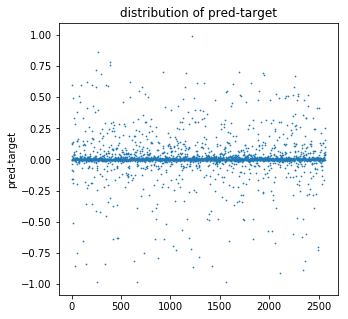

Iteration: 31600, loss: -1.382876992225647
The accuracy is .....
0.038234033


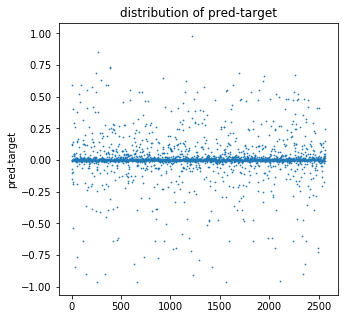

Iteration: 31800, loss: -1.3828736543655396
The accuracy is .....
0.020992348


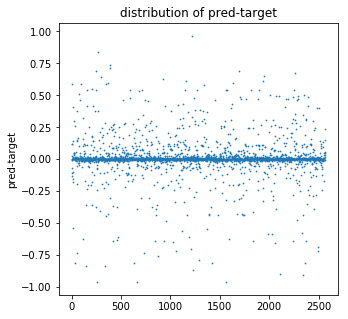

Iteration: 32000, loss: -1.3829034566879272
The accuracy is .....
0.03902561


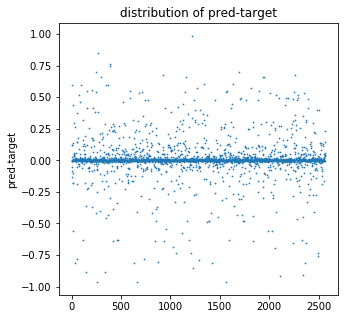

Iteration: 32200, loss: -1.3829001188278198
The accuracy is .....
0.03352565


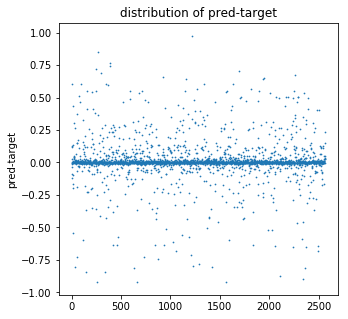

Iteration: 32400, loss: -1.3828895092010498
The accuracy is .....
0.03269558


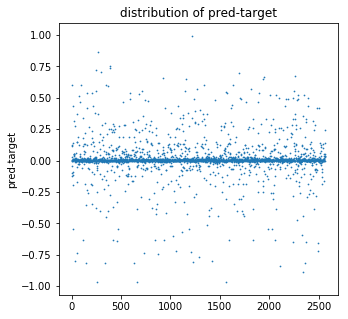

Iteration: 32600, loss: -1.3828710317611694
The accuracy is .....
0.0315048


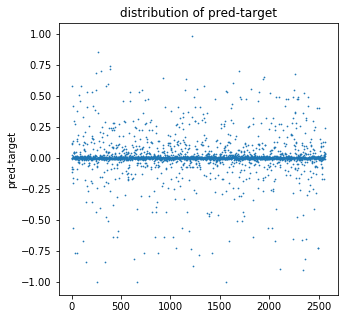

Iteration: 32800, loss: -1.3829585313796997
The accuracy is .....
0.04385584


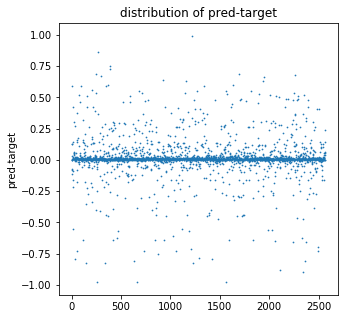

Iteration: 33000, loss: -1.3818453550338745
The accuracy is .....
0.03773911


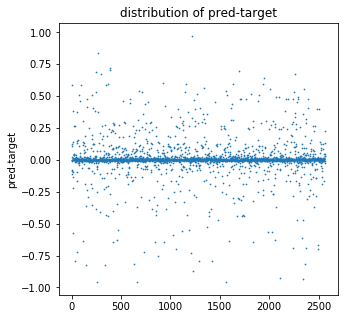

Iteration: 33200, loss: -1.3829712867736816
The accuracy is .....
0.050963487


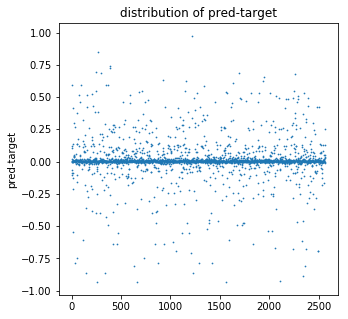

Iteration: 33400, loss: -1.382929801940918
The accuracy is .....
0.04160077


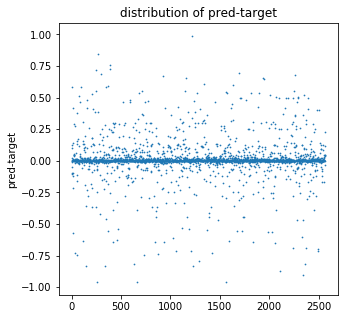

Iteration: 33600, loss: -1.3830052614212036
The accuracy is .....
0.043834947


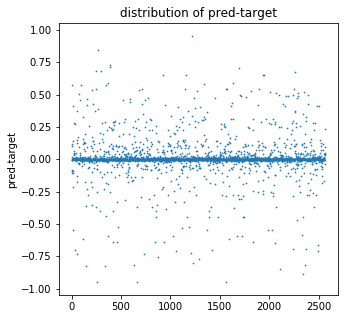

Iteration: 33800, loss: -1.3828496932983398
The accuracy is .....
0.036629837


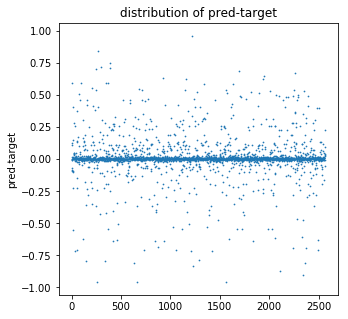

Iteration: 34000, loss: -1.382860541343689
The accuracy is .....
0.047631424


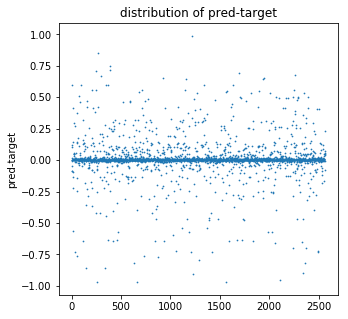

Iteration: 34200, loss: -1.3829606771469116
The accuracy is .....
0.03517469


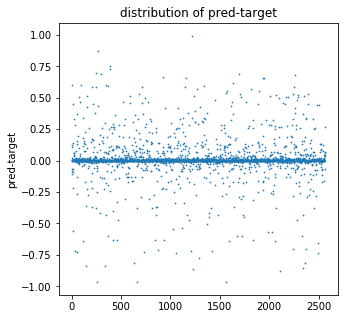

Iteration: 34400, loss: -1.3830374479293823
The accuracy is .....
0.04478676


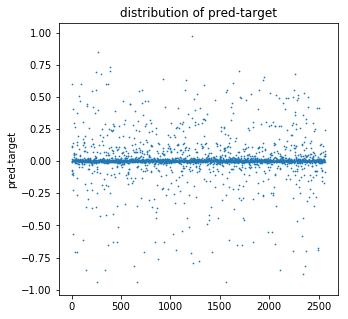

Iteration: 34600, loss: -1.3829874992370605
The accuracy is .....
0.055379834


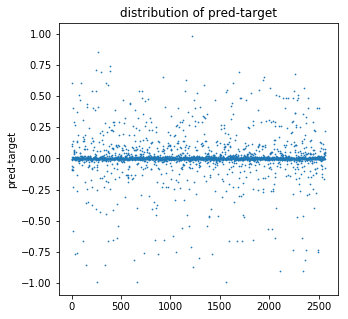

Iteration: 34800, loss: -1.3828777074813843
The accuracy is .....
0.05650933


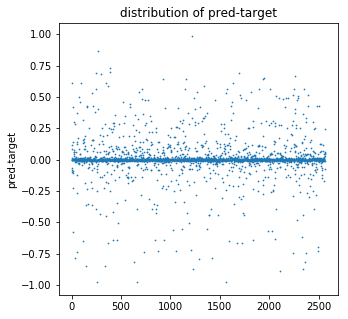

Iteration: 35000, loss: -1.382630705833435
The accuracy is .....
0.031025523


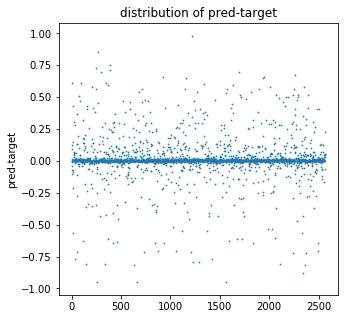

Iteration: 35200, loss: -1.3830368518829346
The accuracy is .....
0.034237698


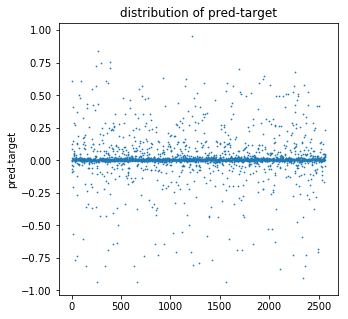

Iteration: 35400, loss: -1.3827728033065796
The accuracy is .....
0.04575381


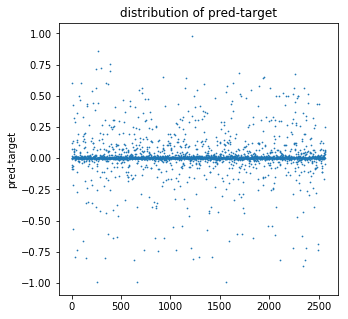

Iteration: 35600, loss: -1.3830639123916626
The accuracy is .....
0.045616377


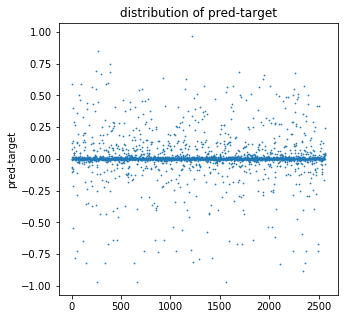

Iteration: 35800, loss: -1.383110761642456
The accuracy is .....
0.033763938


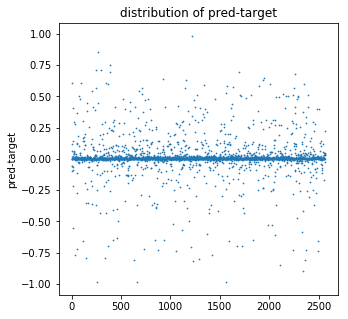

Iteration: 36000, loss: -1.3829667568206787
The accuracy is .....
0.050852664


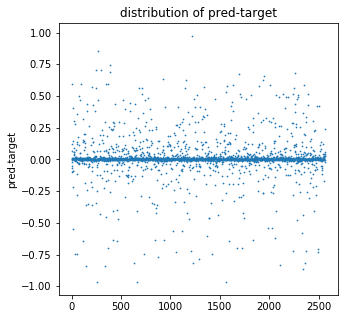

Iteration: 36200, loss: -1.3830502033233643
The accuracy is .....
0.039317697


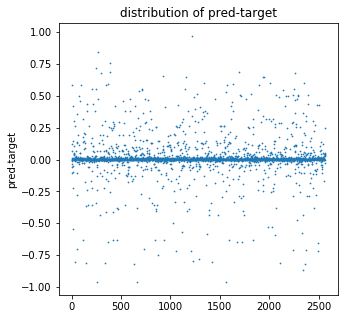

Iteration: 36400, loss: -1.3831150531768799
The accuracy is .....
0.0435989


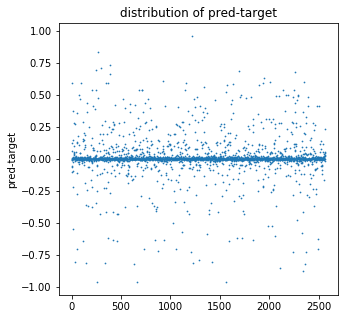

Iteration: 36600, loss: -1.3830021619796753
The accuracy is .....
0.03739024


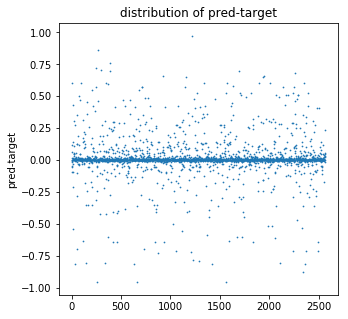

Iteration: 36800, loss: -1.3831225633621216
The accuracy is .....
0.026019672


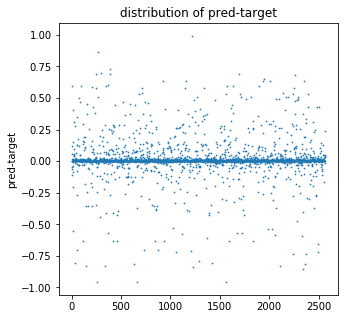

Iteration: 37000, loss: -1.3828284740447998
The accuracy is .....
0.02633715


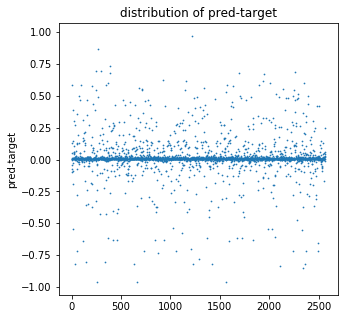

Iteration: 37200, loss: -1.3820394277572632
The accuracy is .....
0.028535916


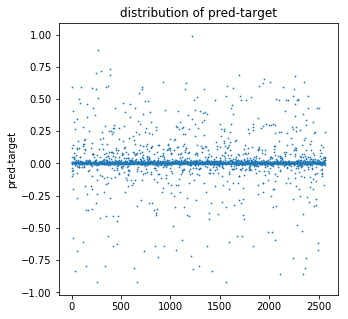

Iteration: 37400, loss: -1.3829739093780518
The accuracy is .....
0.025724381


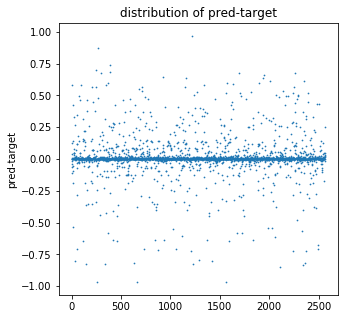

Iteration: 37600, loss: -1.3831727504730225
The accuracy is .....
0.036799468


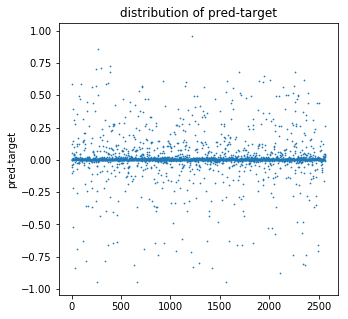

Iteration: 37800, loss: -1.3830747604370117
The accuracy is .....
0.04789688


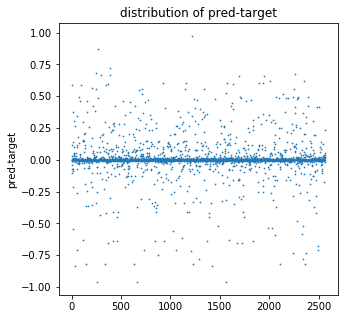

Iteration: 38000, loss: -1.382854700088501
The accuracy is .....
0.027749924


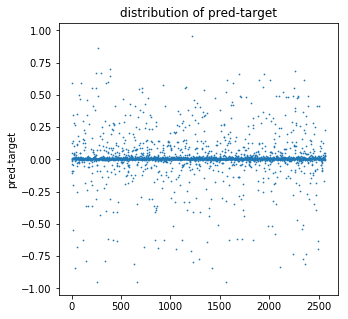

Iteration: 38200, loss: -1.382957100868225
The accuracy is .....
0.036540646


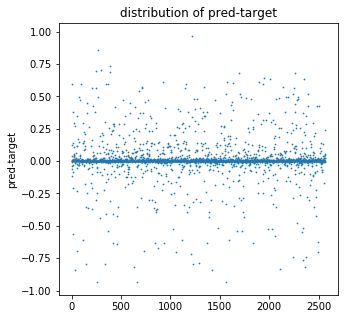

Iteration: 38400, loss: -1.3832069635391235
The accuracy is .....
0.036821645


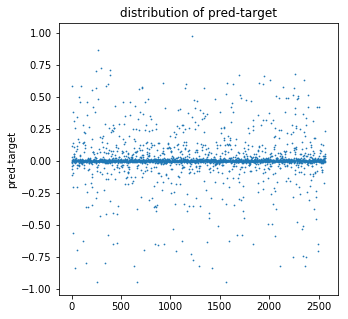

Iteration: 38600, loss: -1.383050560951233
The accuracy is .....
0.042587083


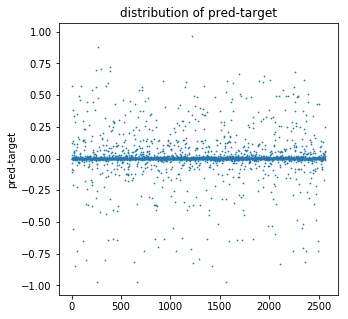

Iteration: 38800, loss: -1.383167028427124
The accuracy is .....
0.03561405


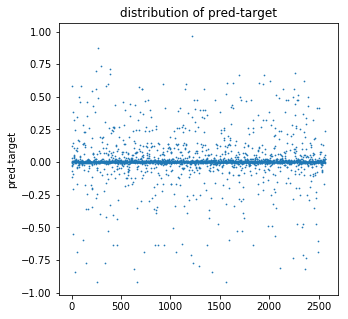

Iteration: 39000, loss: -1.3832250833511353
The accuracy is .....
0.038384337


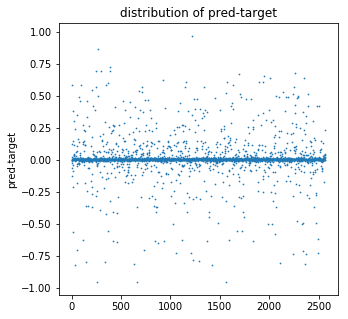

Iteration: 39200, loss: -1.3832309246063232
The accuracy is .....
0.032840725


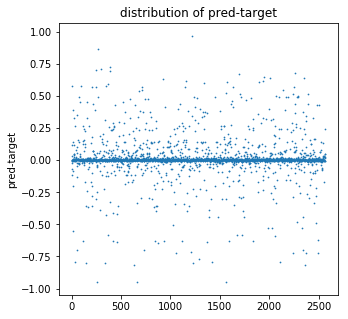

Iteration: 39400, loss: -1.3831905126571655
The accuracy is .....
0.04647045


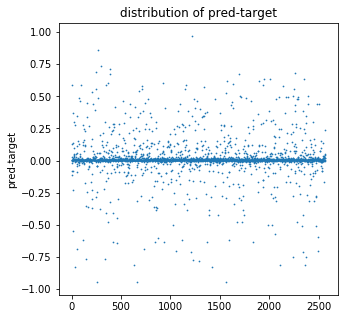

Iteration: 39600, loss: -1.3828835487365723
The accuracy is .....
0.03556208


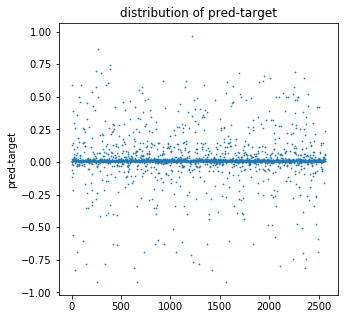

Iteration: 39800, loss: -1.3806532621383667
The accuracy is .....
0.041517597


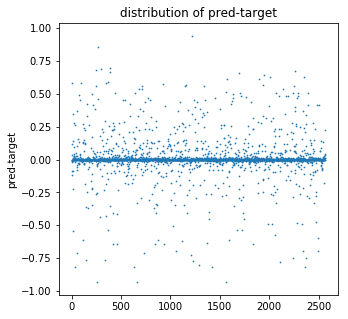

Iteration: 40000, loss: -1.3829710483551025
The accuracy is .....
0.04909656


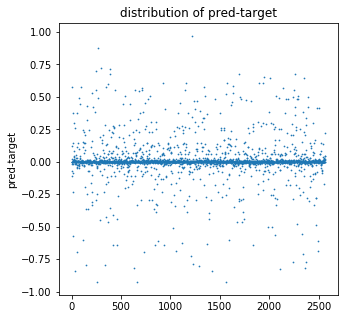

Iteration: 40200, loss: -1.3832072019577026
The accuracy is .....
0.04345236


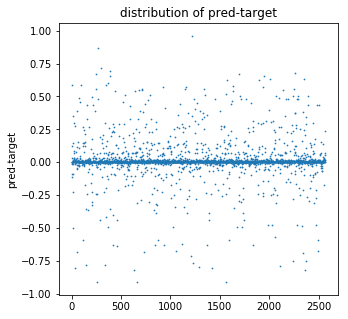

Iteration: 40400, loss: -1.3831087350845337
The accuracy is .....
0.02419081


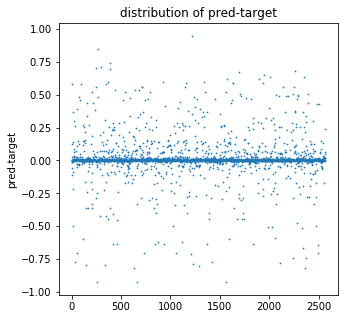

Iteration: 40600, loss: -1.3831979036331177
The accuracy is .....
0.04003516


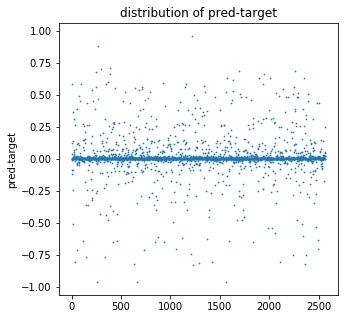

Iteration: 40800, loss: -1.383177399635315
The accuracy is .....
0.038490433


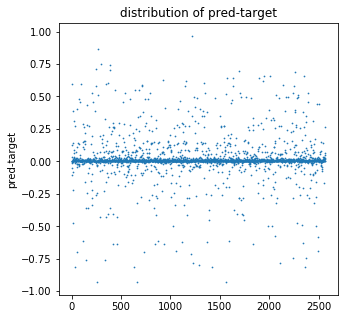

Iteration: 41000, loss: -1.38254714012146
The accuracy is .....
0.0338971


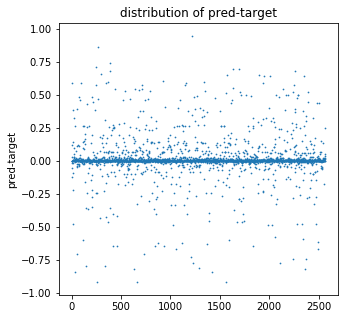

Iteration: 41200, loss: -1.3832168579101562
The accuracy is .....
0.038514398


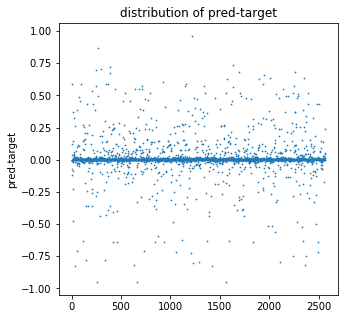

Iteration: 41400, loss: -1.3832441568374634
The accuracy is .....
0.040575907


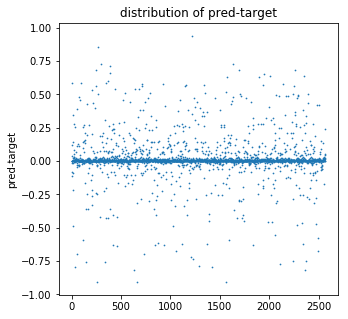

Iteration: 41600, loss: -1.3832370042800903
The accuracy is .....
0.035332747


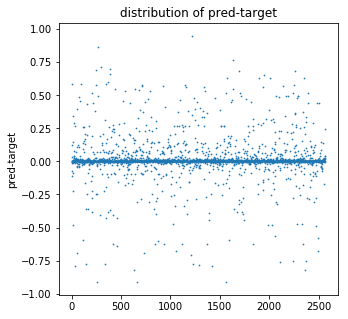

Iteration: 41800, loss: -1.3831932544708252
The accuracy is .....
0.03361564


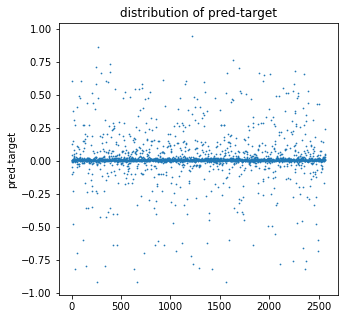

Iteration: 42000, loss: -1.3829467296600342
The accuracy is .....
0.025737826


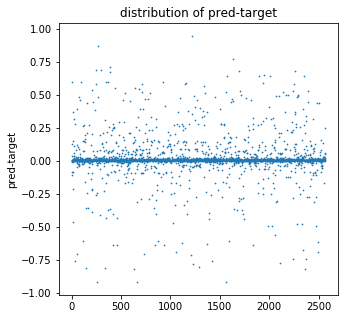

Iteration: 42200, loss: -1.3830419778823853
The accuracy is .....
0.03453085


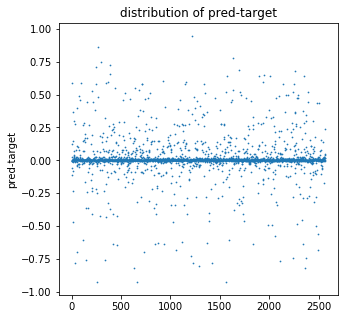

Iteration: 42400, loss: -1.383313536643982
The accuracy is .....
0.035358287


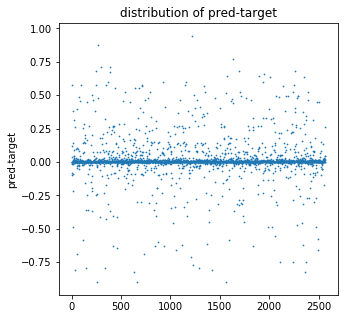

Iteration: 42600, loss: -1.3832435607910156
The accuracy is .....
0.041041493


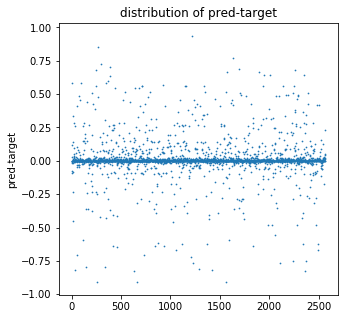

Iteration: 42800, loss: -1.3832982778549194
The accuracy is .....
0.032636896


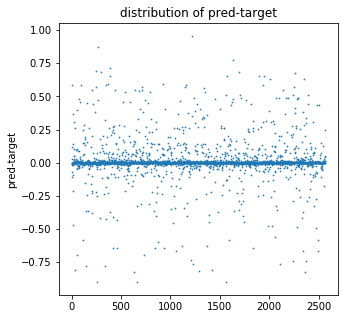

Iteration: 43000, loss: -1.383212685585022
The accuracy is .....
0.040216748


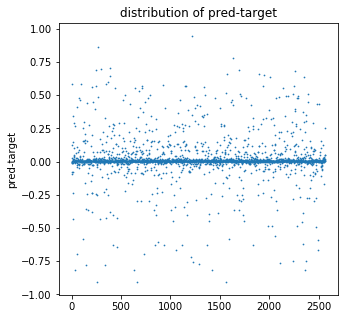

Iteration: 43200, loss: -1.3831088542938232
The accuracy is .....
0.038116034


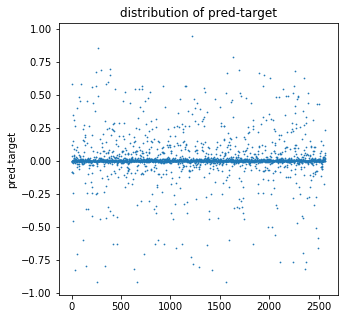

Iteration: 43400, loss: -1.3832898139953613
The accuracy is .....
0.03344993


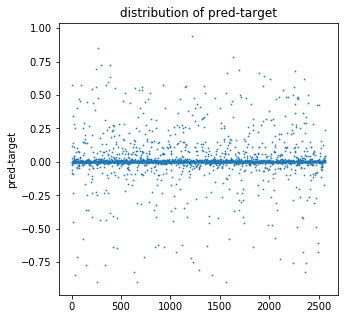

Iteration: 43600, loss: -1.3833485841751099
The accuracy is .....
0.03782214


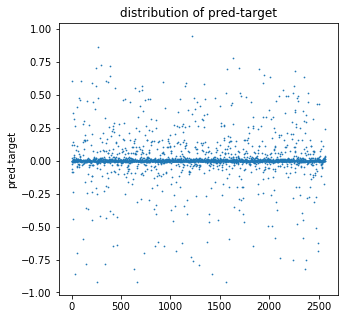

Iteration: 43800, loss: -1.3832473754882812
The accuracy is .....
0.04042257


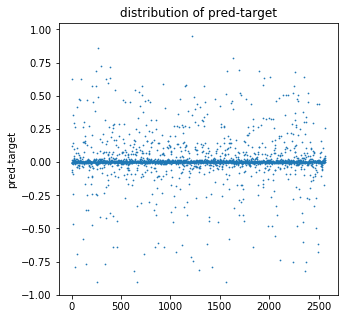

Iteration: 44000, loss: -1.3833444118499756
The accuracy is .....
0.033170853


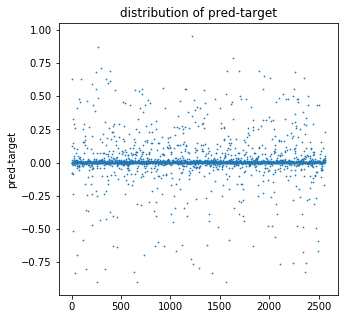

Iteration: 44200, loss: -1.3833227157592773
The accuracy is .....
0.041215274


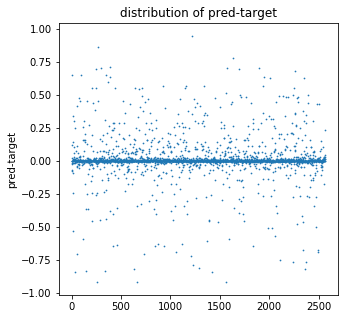

Iteration: 44400, loss: -1.38331937789917
The accuracy is .....
0.035667203


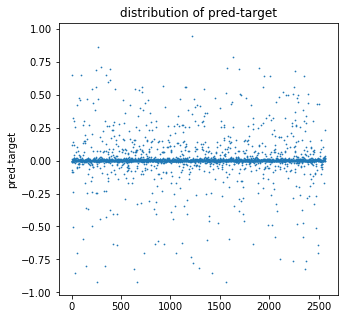

Iteration: 44600, loss: -1.383322834968567
The accuracy is .....
0.034738906


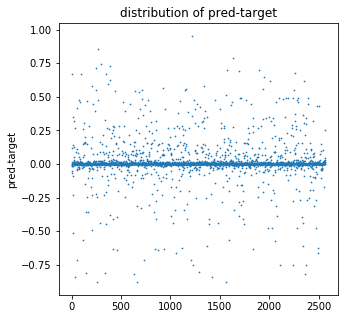

Iteration: 44800, loss: -1.3833611011505127
The accuracy is .....
0.03712126


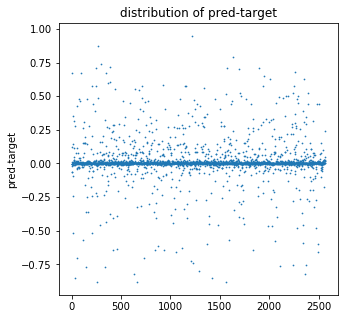

Iteration: 45000, loss: -1.3833649158477783
The accuracy is .....
0.036133103


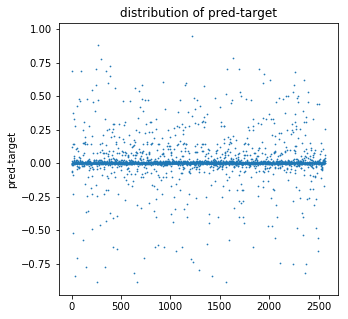

Iteration: 45200, loss: -1.3833767175674438
The accuracy is .....
0.054014865


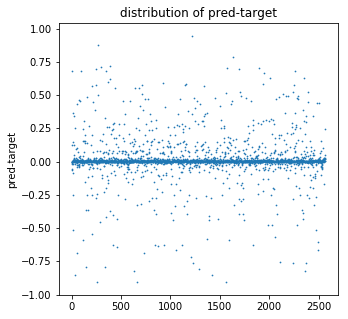

Iteration: 45400, loss: -1.383385419845581
The accuracy is .....
0.04497826


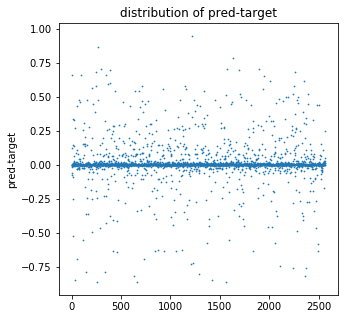

Iteration: 45600, loss: -1.38338041305542
The accuracy is .....
0.049227756


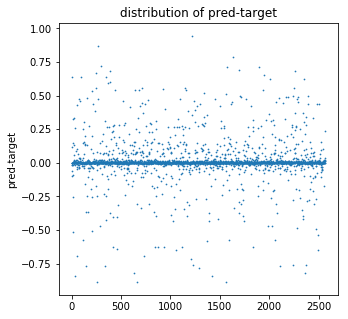

Iteration: 45800, loss: -1.3833754062652588
The accuracy is .....
0.037156876


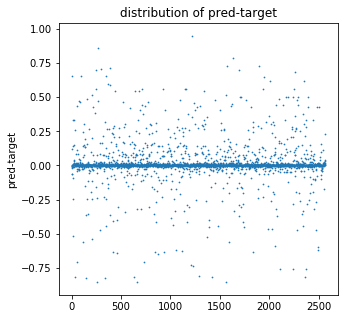

Iteration: 46000, loss: -1.3833916187286377
The accuracy is .....
0.046623453


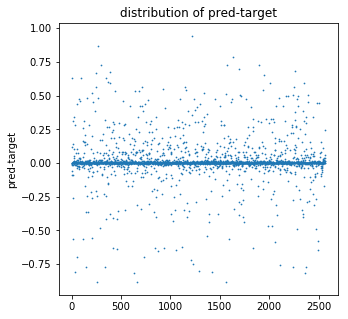

Iteration: 46200, loss: -1.3833670616149902
The accuracy is .....
0.043941032


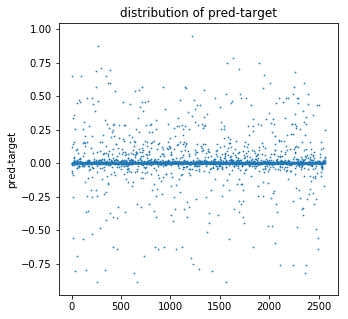

Iteration: 46400, loss: -1.383352279663086
The accuracy is .....
0.051987782


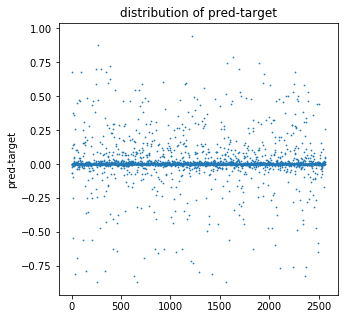

Iteration: 46600, loss: -1.383387804031372
The accuracy is .....
0.037970655


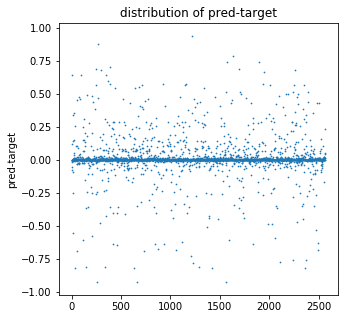

Iteration: 46800, loss: -1.383405089378357
The accuracy is .....
0.045572214


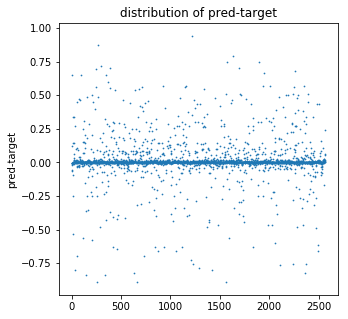

Iteration: 47000, loss: -1.3833829164505005
The accuracy is .....
0.041664


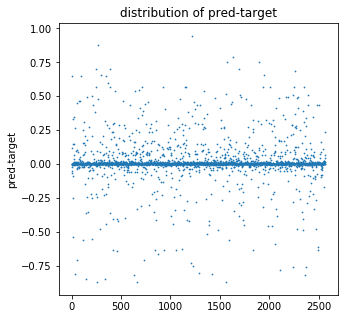

Iteration: 47200, loss: -1.3833039999008179
The accuracy is .....
0.037057888


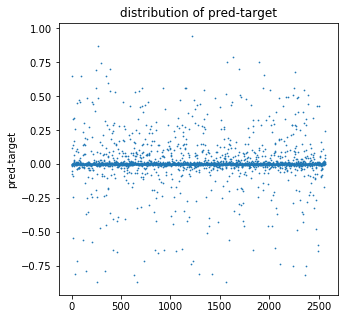

Iteration: 47400, loss: -1.3834117650985718
The accuracy is .....
0.05841722


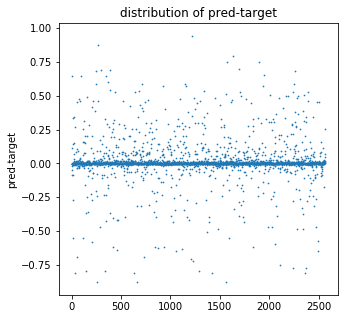

Iteration: 47600, loss: -1.3832916021347046
The accuracy is .....
0.0446636


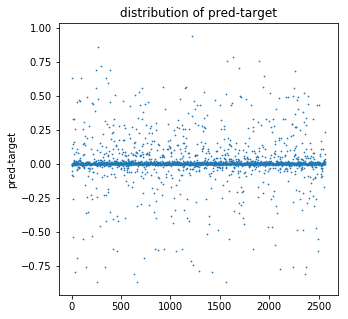

Iteration: 47800, loss: -1.383354663848877
The accuracy is .....
0.049492847


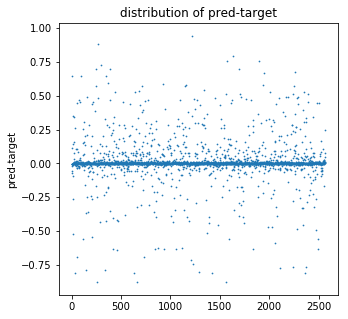

Iteration: 48000, loss: -1.3833857774734497
The accuracy is .....
0.042257912


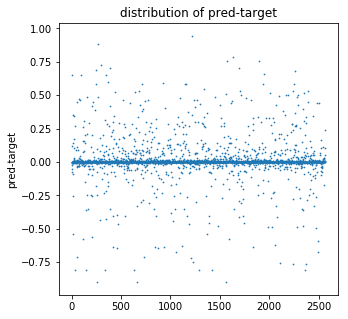

Iteration: 48200, loss: -1.3833986520767212
The accuracy is .....
0.042843778


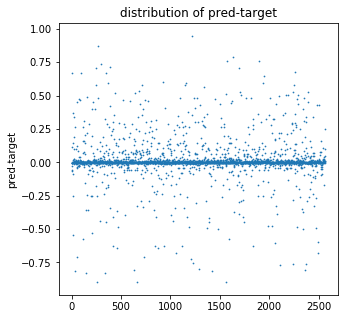

Iteration: 48400, loss: -1.3832257986068726
The accuracy is .....
0.047512583


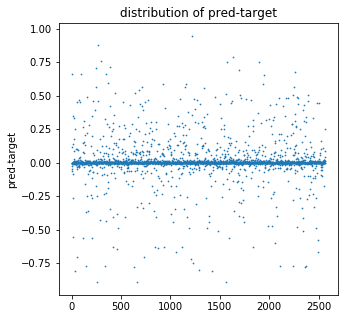

Iteration: 48600, loss: -1.3832765817642212
The accuracy is .....
0.0508537


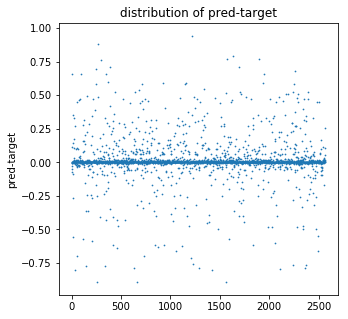

Iteration: 48800, loss: -1.3834317922592163
The accuracy is .....
0.037960276


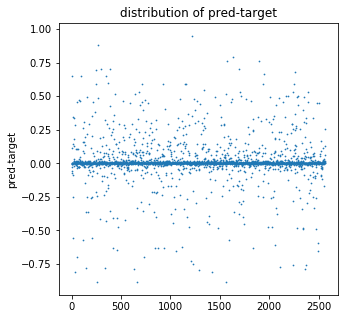

Iteration: 49000, loss: -1.3834269046783447
The accuracy is .....
0.050065104


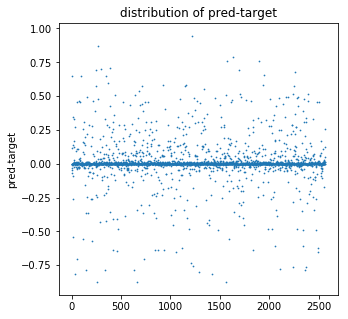

Iteration: 49200, loss: -1.383360505104065
The accuracy is .....
0.053481188


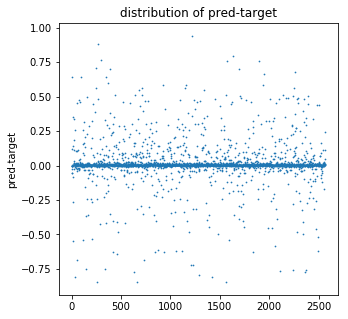

Iteration: 49400, loss: -1.383402705192566
The accuracy is .....
0.049644314


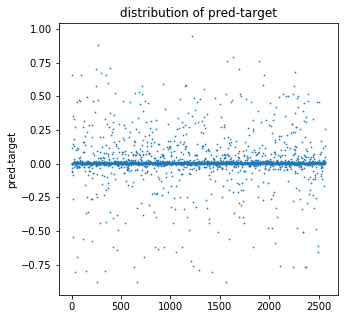

Iteration: 49600, loss: -1.3833636045455933
The accuracy is .....
0.05245855


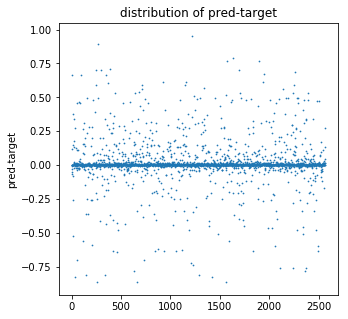

Iteration: 49800, loss: -1.3833627700805664


In [20]:
TRAINING_ITERATIONS = 50000 #@param {type:"number"}
MAX_CONTEXT_POINTS = 50 #@param {type:"number"}
PLOT_AFTER = 200 #@param {type:"number"}
HIDDEN_SIZE = 128 #@param {type:"number"}
MODEL_TYPE = 'ANP' #@param ['NP','ANP']
ATTENTION_TYPE = 'multihead' #@param ['uniform','laplace','dot_product','multihead']
random_kernel_parameters=True #@param {type:"boolean"}

tf.reset_default_graph()

# Sizes of the layers of the MLPs for the encoders and decoder
# The final output layer of the decoder outputs two values, one for the mean and
# one for the variance of the prediction at the target location
latent_encoder_output_sizes = [HIDDEN_SIZE]*4
num_latents = HIDDEN_SIZE
deterministic_encoder_output_sizes= [HIDDEN_SIZE]*4
decoder_output_sizes = [HIDDEN_SIZE]*2 + [2]
use_deterministic_path = True

# ANP with multihead attention
if MODEL_TYPE == 'ANP':
  attention = Attention(rep='mlp', output_sizes=[HIDDEN_SIZE]*2, 
                        att_type='multihead')
# NP - equivalent to uniform attention
elif MODEL_TYPE == 'NP':
  attention = Attention(rep='identity', output_sizes=None, att_type='uniform')
else:
  raise NameError("MODEL_TYPE not among ['ANP,'NP']")

# Define the model
model = LatentModel(latent_encoder_output_sizes, num_latents,
                    decoder_output_sizes, use_deterministic_path, 
                    deterministic_encoder_output_sizes, attention)

# Define data
batch_size = 50
train_query, train_target_y, train_num_total_points, train_num_context_points = datawrap(train_norm_x, train_norm_y, batch_size)

test_query, test_target_y, test_num_total_points, test_num_context_points = testdatawrap(test_norm_x, test_norm_y, test_norm_x.shape[0])

# Define the loss
_, _, log_prob, _, loss = model(train_query, train_num_total_points,
                                 train_target_y)

# Get the predicted mean and variance at the target points for the testing set
mu, sigma, _, _, _ = model(test_query, test_num_total_points)

# Set up the optimizer and train step
optimizer = tf.train.AdamOptimizer(1e-4)
train_step = optimizer.minimize(loss)
init = tf.initialize_all_variables()

# Train and plot
with tf.train.MonitoredSession() as sess:
  sess.run(init)

  for it in range(TRAINING_ITERATIONS):
    sess.run([train_step])

    # Plot the predictions in `PLOT_AFTER` intervals
    if it % PLOT_AFTER == 0:
      loss_value, pred_y, std_y, target_y, whole_query = sess.run(
          [loss, mu, sigma, test_target_y, 
           test_query])
      print("The accuracy is .....")
      accuracy = abs(pred_y-target_y)/target_y
      accuracy = np.reshape(accuracy, accuracy.shape[1])
      print(np.mean(accuracy))
      acc = pred_y - target_y
      plt.figure(figsize=(5,5)) 
      plt.scatter(np.arange(acc.shape[1]), acc, s=0.5)
      plt.xlabel('')
      plt.ylabel('pred-target')
      plt.title(r'distribution of pred-target')
      plt.show()
     
      (context_x, context_y), target_x = whole_query
      print('Iteration: {}, loss: {}'.format(it, loss_value))

      # Plot the prediction and the context
      #plot_functions(target_x, target_y, context_x, context_y, pred_y, std_y)

## **Evaluation**

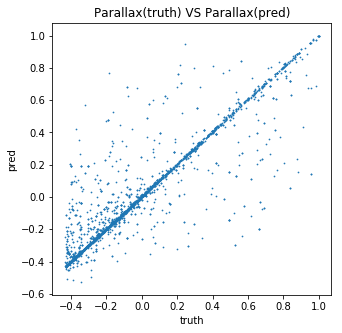

In [21]:


plt.figure(figsize=(5,5)) 
plt.scatter(target_y, pred_y, s=0.5)
plt.xlabel('truth')
plt.ylabel('pred')
plt.title(r'Parallax(truth) VS Parallax(pred)')
plt.show()

In [0]:
acc = abs(pred_y - target_y)/target_y
print(np.median(abs(pred_y - target_y)/target_y))

-0.112290725


(1, 2567, 1)


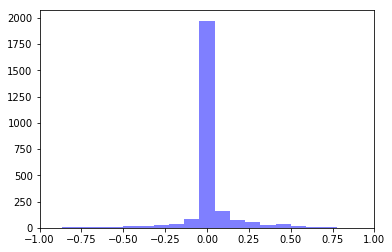

In [31]:
#show the distribution of (pred_y - target_y)/target_y
num_bins = 20
acc = pred_y - target_y
print(acc.shape)
n, bins, patches = plt.hist(acc[0], num_bins, facecolor='blue', alpha=0.5)
plt.xlim(-1, 1)
plt.show()

# **Log**
###(1)
###Select parallax between 0 and 4
###select parallax error between 0 and 0.5
###total points: 192289
###train with 50000 points
###lr: 1e-3
###result: failed (the size of data does not make sense)

###(2)
###Select parallax between 3 and 4
###select parallax error between 0 and 0.5
###total points: 8925
###lr: 1e-3, 1e-4
###train with 8400 points
###result: failed

###(3)
###Select parallax between 1 and 4
###select parallax error between 0 and 0.5
###total points: 89250
###lr: 1e-3, 1e-4
###train with 20000 points
###result: failed

###(4)
###Select parallax between 0 and 0.5
###select parallax error between 0 and 0.5
###total points: 48127
###lr: 1e-3, 1e-4
###train with 20000 points
###result: failed

###(5)
###Select parallax between 1 and 1.5
###select parallax error between 0 and 0.5
###total points: 34760
###lr: 1e-3, 1e-4
###train with 20000 points
###result: failed